# Mitigating Director Gender Bias in Movie Recommender Systems

By: Michael Garcia-Perez & Christine Deng with mentors Emily Ramond, Parker Addison, Greg Thein from Deloitte

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development & Evaluation](#3.-Model-Development-&-Evaluation)

[4. Bias Mitigation](#4.-Bias-Mitigation)

[5. Results Summary](#5.-Results-Summary)

[6. Conclusion & Discussion](#6.-Conclusion-&-Discussion)

### [1.](#Table-of-Contents) Introduction

Past literature across sociology and media studies have widely studied the gender gap in the film industry, namely the underrepresentation of female directors in film production. A comprehensive analysis of over 2000 films released between 1994 and 2016 showed that only 5% of the directors were female (<a href="https://doi.org/10.1177/00222437221100217">Karniouchina et al., 2023</a>). Another study on the gender composition of directors in top-grossing films released between 2007 and 2021 revealed that the ratio of male to female directors was 11:1 (<a href="https://ca-times.brightspotcdn.com/32/1f/434e9de042a9a366c08aac1ed1db/inclusion-in-the-director-2.8.22%20Final.pdf">Smith et al., 2017</a>).

Despite previous research drawing light to the presence of this gender gap in the film industry, the implications of this disparity on recommendation systems is not widely researched. Many content distribution platforms, such as Netflix, utilize recommendation models for personalized user content. A recommender system filters information (e.g., user and item data) to provide personalized suggestions to users. Our project investigates whether this gender bias is embedded into the outputs and suggestions of various recommendation models developed using different similarity metrics and algorithms. 

Additionally, widely adopted bias mitigation tools (such as IBM's AI Fairness 360 open source toolkit) are optimized for regression and classification tasks. The current documentation does not specifically provide any support for bias mitigation in the context of recommender systems, whereas there are specific references to the popular machine learning toolkit scikit-learn's Classifier and Regressor modules. Even research solely on recommender models remains limited in the context of ethical biases, as most studies look at bias from a statistical perspective (e.g., popularity bias). Our project fills this gap by investigating whether bias mitigation techniques developed for regression and classification tasks can be extended to recommendation systems. Our aim is to develop a fair movie recommender system that minimizes biases associated with the gender of the director.

### [2.](#Table-of-Contents) Exploratory Data Analysis

### Import Statements

We use several external libraries in our project, which provide pre-built functions and classes.

Most importantly, we utilize IBM's AI Fairness 360 open source toolkit to detect and mitigate bias in machine learning models. Documentation for AIF360 can be found <a href="https://aif360.readthedocs.io/en/stable/index.html">here</a>. The toolkit allows us to import bias mitigation techniques and to quantiatively assess various metrics.

Surprise is a toolkit developed for Python that builds recommender systems optimized for rating data. This toolkit is utilized to develop a matrix factorization-based recommender system. Documentation for Surprise can be found <a href="https://surpriselib.com/">here</a>.

In [1]:
%%capture

# Install necessary packages
!pip install 'aif360[LawSchoolGPA]' > /dev/null
!pip install 'aif360' > /dev/null
!pip install --upgrade tensorflow aif360 > /dev/null
!pip install protobuf==3.19.0 > /dev/null
!pip install 'aif360[AdversarialDebiasing]' > /dev/null
!pip install scikit-surprise > /dev/null
!pip install seaborn > /dev/null

In [2]:
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Import statements
import random
import gzip
import json
import numpy as np
import math
import pandas as pd
import scipy.optimize
import string
import random
import os
import re
import tarfile
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.metrics import jaccard_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as sklearn_train_test_split
     
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import SVD
from surprise import accuracy
     
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
     
from scipy.stats import pearsonr
from IPython.display import Markdown, display

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Getting the data

### Reading File Path (Ratings, Users, Movies, Directors, Titles)

The <a href="https://grouplens.org/datasets/movielens/1m/">data</a> for user ratings is sourced from <a href="https://movielens.org/">MovieLens</a>, an online platform that provides personalized movie recommendations based on users' viewing preferences and rating history. These files contain 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined the platform in 2000.

In [3]:
# Update file paths based on extraction path
extract_path = ""

# Ratings File
ratings_file = os.path.join(extract_path, "ratings.dat")
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv(ratings_file, sep="::", engine="python", header=None, names=ratings_columns, encoding='latin1')

# Movies File
movies_file = os.path.join(extract_path, "movies.dat")
movies_columns = ["MovieID", "Title", "Genres"]
movies_df = pd.read_csv(movies_file, sep="::", engine="python", header=None, names=movies_columns, encoding='latin1')

Each user is uniquely identified by a distinct user ID. Similarly, each movie also has its own unique movie ID.

User ratings fall on a discrete scale ranging from 1 to 5, where a rating of 1 denotes the lowest level of enjoyment with the movie, while a rating of 5 signifies the highest level.

Each row in the dataset corresponds to a single movie rating by a single user. Users can only rate a movie once.

In [4]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Each movie with its unique ID has information on the title, genres, and year.

In [5]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


No information about the movie's director is present in the MovieLens dataset.

The <a href="https://figshare.com/articles/dataset/U_S_movies_with_gender-disambiguated_actors_directors_and_producers/4967876">dataset</a> on the gender of the directors comes from Northwestern University's Amaral Lab, which looks at the gender breakdown of the crew of U.S. films released between 1894 and 2011.

In [6]:
# Directors File
directors_file = os.path.join(extract_path, "directors.json")
directors_df = pd.read_json(directors_file)

The relevant columns in this dataset are the gender of the director, as well as the list of movies they have directed. The movies in the list are not identified by title, but rather their unique numerical identifier assigned by IMDb, the world's most popular media database.

In [7]:
directors_df.head()

,first_movie,actress_credits,male_count,_id,gender,name,female_count,last_movie,actor_credits,movies_list
0,1940,False,272,nm0000033,male,Alfred Hitchcock,13,1976,True,"[{'movie_id': 'tt0046912', 'year': 1954, 'type..."
1,1917,False,247,nm0000036,male,Buster Keaton,7,1939,True,"[{'movie_id': 'tt0011541', 'year': 1920, 'type..."
2,1951,False,366,nm0000040,male,Stanley Kubrick,24,1980,True,"[{'movie_id': 'tt0062622', 'year': 1968, 'type..."
3,1968,False,253,nm0000056,male,Paul Newman,15,1987,True,"[{'movie_id': 'tt0093093', 'year': 1987, 'type..."
4,1996,False,59,nm0000114,male,Steve Buscemi,1,2007,True,"[{'movie_id': 'tt0480269', 'year': 2007, 'type..."


As such, we also utilize <a href="https://datasets.imdbws.com/">IMDb's dataset</a> on titles and identifiers. Each row represents a single movie, with relevant columns being its unique identifier, title, and year.

In [8]:
# Titles File
titles_file = os.path.join(extract_path, "title.basics.tsv.gz")
titles_df = pd.read_csv(titles_file, compression='gzip', sep='\t', encoding='utf-8')

In [9]:
titles_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


### Separting Title of Movie from the Year in Movies Dataframe

To clean the dataset, we separate the title of the movie from the year and create a separate column to record the movie's release year.

In [10]:
# Separate title of movie from the year
movies_df['Year'] = movies_df['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)
movies_df['Title'] = movies_df['Title'].apply(lambda x: re.sub(r'\(\d{4}\)', '', x).strip())
movies_df.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


IMDb also records information on television series, podcasts, video games, and other media forms. Our user ratings from MovieLens only look at movies, so these mediums are irrelevant. We drop the data associated with these mediums.

In [11]:
# Filter data to get only titles that are movies
titles_df = titles_df[titles_df['titleType'] == 'movie']
titles_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama


### Merge the Movies Dataframe and Titles Dataframe Together Given Movie Title and Year

We join the movie information in the user ratings with the movie information in IMDb's title dataset to link the unique identifier. The identifier is linked to the movie if the title and year match in both datasets, since MovieLens sources its titles from IMDb. Repeated columns (e.g., title, year, genres) are dropped, as well as irrelevant columns (e.g., runtime).

In [12]:
# Merge datasets using movie title and year
movie_ids = pd.merge(movies_df, titles_df, left_on=['Title', 'Year'], right_on=['primaryTitle', 'startYear'], how='left')
movie_ids = movie_ids[['MovieID', 'Title', 'Genres', 'Year', 'tconst']]
movie_ids.head()

,MovieID,Title,Genres,Year,tconst
0,1,Toy Story,Animation|Children's|Comedy,1995,tt0114709
1,2,Jumanji,Adventure|Children's|Fantasy,1995,tt0113497
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228
3,4,Waiting to Exhale,Comedy|Drama,1995,tt0114885
4,5,Father of the Bride Part II,Comedy,1995,tt0113041


### Get Director Gender for Each Movie

Because directors have multiple movies directed in their careers, we rearrange the dataset so that each row will be associated with a single director for a single movie (rather than a single row for a single director, with all their movies grouped together). This means that directors who have directed more than one movie will appear in several rows.

Also note that a single movie can have more than one director. So, each movie can also appear in several rows.

In [13]:
# Find director's gender of each movie identifier associated with the director
genders = directors_df.explode('movies_list')
genders = pd.concat([genders.drop(['movies_list'], axis=1),
                         genders['movies_list'].apply(pd.Series)], axis=1)

### Merging User Rating Movie Information and Director Gender Data

Now that both the user ratings data and the director gender data have the IMDb identifier, the datasets can be combined by matching the identifiers together.

In [14]:
# Combine datasets based on movie identifier 
merged_df = pd.merge(movie_ids, genders, left_on='tconst', right_on='movie_id', how='left')
merged_df = merged_df.loc[:, ['MovieID', 'Title', 'Genres', 'Year', 'gender', 'name']]
merged_df.head()

,MovieID,Title,Genres,Year,gender,name
0,1,Toy Story,Animation|Children's|Comedy,1995,male,John Lasseter
1,2,Jumanji,Adventure|Children's|Fantasy,1995,male,Joe Johnston
2,3,Grumpier Old Men,Comedy|Romance,1995,male,Howard Deutch
3,4,Waiting to Exhale,Comedy|Drama,1995,male,Forest Whitaker
4,5,Father of the Bride Part II,Comedy,1995,male,Charles Shyer


### Checking for Null Values for Each Dataframe

Before we proceed with any analysis, we examine the distributions and values of the dataset to check for missing values.

In [15]:
# Check for proportion of missing data in movie information
merged_df.isnull().sum() / merged_df.shape[0]

MovieID    0.00000
Title      0.00000
Genres     0.00000
Year       0.00000
gender     0.56348
name       0.56348
dtype: float64

In [16]:
# Check for proportion of missing data in user ratings
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

No data is missing in the user ratings. To check for placeholder values, we check all values of rating scores. The only values are discrete numbers from 1 through 5, which means there are no placeholder values for missing data.

In [17]:
# Check all values of rating scores
ratings_df['Rating'].value_counts()

Rating
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64

### Creating New Binary Feature to Identify Entirely Male Directed Movies

Movies can have more than one director, so we cannot simply assign each movie to whether it's directed by a male or female. We create a new column that denotes the proportion of directors for each movie who are identifies as male. A movie directed fully by males will have a male_director_proportion of 1.0, and a movie directed fully by females will have a male_director_proportion of 0.0.

In [18]:
# Replace 'male' and 'female' columns with numerical binary values
# A value of 0 maps to 'female', while a value of 1 maps to 'male'.
merged_df['gender'] = merged_df['gender'].replace({'female': 0, 'male': 1})
merged_df.head()

# Find proportion of male directors for each movie
male_prop_dict = dict(merged_df.groupby('MovieID')['gender'].sum() / merged_df.groupby('MovieID')['gender'].count())

# Add column with proportion of male directors
merged_df['male_director_proportion'] = merged_df['MovieID'].map(male_prop_dict)
merged_df.drop_duplicates(subset=['MovieID'], inplace=True)

merged_df.head()

,MovieID,Title,Genres,Year,gender,name,male_director_proportion
0,1,Toy Story,Animation|Children's|Comedy,1995,1.0,John Lasseter,1.0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,1.0,Joe Johnston,1.0
2,3,Grumpier Old Men,Comedy|Romance,1995,1.0,Howard Deutch,1.0
3,4,Waiting to Exhale,Comedy|Drama,1995,1.0,Forest Whitaker,1.0
4,5,Father of the Bride Part II,Comedy,1995,1.0,Charles Shyer,1.0


To prepare our data for model development, we binarize the male_director_proportion column. Binarization involves categorizing the variable into two distinct groups based on a specified threshold. To determine this threshold, we examine the distribution of the male_director_proportion across our dataset.

In [19]:
merged_df['male_director_proportion'].value_counts()

male_director_proportion
1.000000    1498
0.000000      78
0.500000      22
0.666667       2
0.750000       1
Name: count, dtype: int64

Binarizing our variables consists of converting our proportions to binary values of either 0 or 1. We considered rounding the proportion to the closest number of either 0 or 1, but that would result in only a few data points being 0 (as most male_director_proportions are >= 0.5). There would be a strong imbalance between 0s and 1s after binarization due to most movies having a higher proportion of male directors involved.

So, we convert the proportion to 1 if the movie is fully directed by males, and 0 if the movie involves at least one female director (i.e., is not entirely male directed). The value of all_male_director is 1 if male_director_proportion is 1, and the value of all_male_director is 0 otherwise.

In [20]:
merged_df['all_male_director'] = (merged_df['male_director_proportion'] == 1).astype(float)

# Remove rows where the proportion of male directors is unknown
merged_df = merged_df.dropna(subset='male_director_proportion')

merged_df.head()

,MovieID,Title,Genres,Year,gender,name,male_director_proportion,all_male_director
0,1,Toy Story,Animation|Children's|Comedy,1995,1.0,John Lasseter,1.0,1.0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,1.0,Joe Johnston,1.0,1.0
2,3,Grumpier Old Men,Comedy|Romance,1995,1.0,Howard Deutch,1.0,1.0
3,4,Waiting to Exhale,Comedy|Drama,1995,1.0,Forest Whitaker,1.0,1.0
4,5,Father of the Bride Part II,Comedy,1995,1.0,Charles Shyer,1.0,1.0


In [21]:
merged_df['all_male_director'].value_counts()

all_male_director
1.0    1498
0.0     103
Name: count, dtype: int64

This results in a less imbalanced distribution of 0s and 1s, compared to rounding the proportions.

To reiterate, male_director_proportion demonstrates the ratio of male directors out of the total directors for that movie. The column all_male_director has a value of either 0 or 1: 1 if the movie is entirely male-directed, 0 if not (i.e., female directors are involved).

### Creating New Genre Column

Currently, the genre column is stored as a string of multiple genres split by a '|' character. We separate each unique genre into its own distinct column with a value of 1 if the movie is categorized under that genre, and a 0 if not. A movie can have more than one genre, so multiple values of 1 across columns can be present for a single row.

Converting the genres into a binary value of 0 and 1 is necessary to prepare our dataset for model development.

In [22]:
# Split the genres column into a list of genres
merged_df['Genres'] = merged_df['Genres'].str.split('|')

# List of unique genres
unique_genres = set(genre for genres_list in merged_df['Genres'] for genre in genres_list)

# Initialize binary columns for each genre with zeros
for genre in unique_genres:
    merged_df[genre] = 0

# Update binary columns using vectorized operations
for genre in unique_genres:
    merged_df[genre] = merged_df['Genres'].apply(lambda x: 1 if genre in x else 0)

# Drop the original genres column
merged_df = merged_df.drop('Genres', axis=1)

In [23]:
merged_df.head()

,MovieID,Title,Year,gender,name,male_director_proportion,all_male_director,Animation,Fantasy,Crime,...,Documentary,Musical,Mystery,Film-Noir,Thriller,Horror,Comedy,Drama,Adventure,Action
0,1,Toy Story,1995,1.0,John Lasseter,1.0,1.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,Jumanji,1995,1.0,Joe Johnston,1.0,1.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,3,Grumpier Old Men,1995,1.0,Howard Deutch,1.0,1.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,Waiting to Exhale,1995,1.0,Forest Whitaker,1.0,1.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,5,Father of the Bride Part II,1995,1.0,Charles Shyer,1.0,1.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Merging Movies Dataframe with Ratings Dataframe on MovieID to Include Rating and UserID Columns

Now that we have the movie information for the user ratings complete, we combine the unique Movie ID assigned by MovieLens with the full movie information (with director gender) from the merged dataset above.

Each row represents 1 movie rated by 1 user.

For clarity purposes, we rename columns to specify that the gender in the data represents the director's gender, and the rating represents the user's rating. We also drop irrelevant columns, such as the director's name.

In [24]:
# Merge movies with ratings on MovieID
Ratings_and_Movies = pd.merge(merged_df, ratings_df[['MovieID', 'Rating', 'UserID']], on='MovieID').drop('name', axis=1)

# Rename columns for clarity
Ratings_and_Movies.rename(columns={'Rating': 'User_Rating', 'gender': 'Director_Gender'}, inplace=True)

Ratings_and_Movies.head()

,MovieID,Title,Year,Director_Gender,male_director_proportion,all_male_director,Animation,Fantasy,Crime,Children's,...,Mystery,Film-Noir,Thriller,Horror,Comedy,Drama,Adventure,Action,User_Rating,UserID
0,1,Toy Story,1995,1.0,1.0,1.0,1,0,0,1,...,0,0,0,0,1,0,0,0,5,1
1,1,Toy Story,1995,1.0,1.0,1.0,1,0,0,1,...,0,0,0,0,1,0,0,0,4,6
2,1,Toy Story,1995,1.0,1.0,1.0,1,0,0,1,...,0,0,0,0,1,0,0,0,4,8
3,1,Toy Story,1995,1.0,1.0,1.0,1,0,0,1,...,0,0,0,0,1,0,0,0,5,9
4,1,Toy Story,1995,1.0,1.0,1.0,1,0,0,1,...,0,0,0,0,1,0,0,0,5,10


We also rename the columns to use lowercase and underscores to keep the column name style consistent.

In [25]:
# Rename columns to lowercase
column_mapping = {
    'Title': 'title',
    'MovieID': 'movie_id',
    'Year': 'year',
    'User_Rating': 'user_rating',
    'UserID': 'user_id',
    'User_Gender': 'user_gender',
    'Drama': 'drama',
    'Romance': 'romance',
    'Thriller': 'thriller',
    'Action': 'action',
    'Sci-Fi': 'sci_fi',
    'Adventure': 'adventure',
    'Mystery': 'mystery',
    'Comedy': 'comedy',
    "Children's": 'childrens',
    'Animation': 'animation',
    'War': 'war',
    'Western': 'western',
    'Documentary': 'documentary',
    'Film-Noir': 'film_noir',
    'Horror': 'horror',
    'Fantasy': 'fantasy',
    'Crime': 'crime',
    'Musical': 'musical',
    'Director_Gender': 'director_gender',
    'male_director_proportion': 'male_director_proportion',
    'all_male_director': 'all_male_director'
}

Ratings_and_Movies.rename(columns=column_mapping, inplace=True)

We drop duplicate rows where the combination of MovieID and UserID is identical, ensuring that each unique user-movie pair has only one corresponding rating.

We also remove the column with the director's gender because the individual director gender is not necessary to retain, since we have created the new feature of all_male_director above.

In [26]:
# Remove rows with the same MovieID and UserID, and ensure there are no rows with missing information
Ratings_and_Movies = Ratings_and_Movies.dropna(subset=['all_male_director', 'director_gender'])
Ratings_and_Movies.drop_duplicates(subset=['movie_id', 'user_id'], inplace=True)

# Drop the column of individual director gender
Ratings_and_Movies = Ratings_and_Movies.drop('director_gender', axis=1)

Ratings_and_Movies.head()

,movie_id,title,year,male_director_proportion,all_male_director,animation,fantasy,crime,childrens,war,...,mystery,film_noir,thriller,horror,comedy,drama,adventure,action,user_rating,user_id
0,1,Toy Story,1995,1.0,1.0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,5,1
1,1,Toy Story,1995,1.0,1.0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,4,6
2,1,Toy Story,1995,1.0,1.0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,4,8
3,1,Toy Story,1995,1.0,1.0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,5,9
4,1,Toy Story,1995,1.0,1.0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,5,10


### Ratings and Director Gender EDA

Recommender systems look at how users compare across movie ratings, using similarity between users to determine which movies to recommend. By visualizing the distribution of rating scores, we are able to see users' tendencies when rating movies.

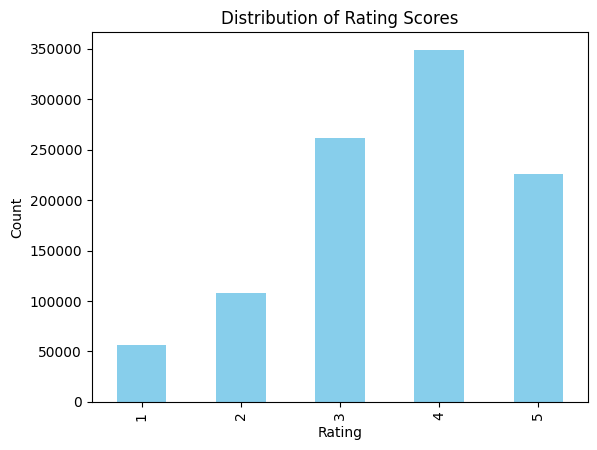

In [27]:
%matplotlib inline

# Count the occurrences of each rating
rating_counts = ratings_df['Rating'].value_counts()

# Sort the ratings in ascending order
rating_counts = rating_counts.sort_index()

# Create a bar plot
rating_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Rating Scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Most ratings are on the higher side with a score of 4. There are less low ratings of 1 & 2 in our dataset.

We further separate this by the director's gender breakdown to compare the proportion of ratings between male versus female directors.

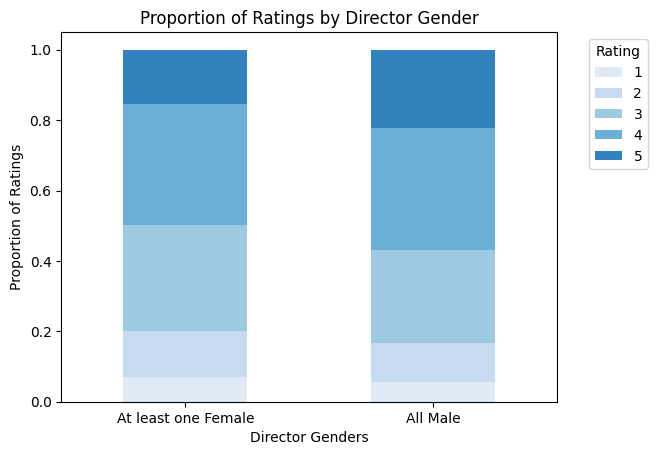

In [28]:
# Ratings categorized by gender of director
rating_counts_by_gender = Ratings_and_Movies.groupby(['all_male_director', 'user_rating']).size().unstack()

# Normalize by the total number of ratings for each director gender
rating_percentage_by_gender = rating_counts_by_gender.div(rating_counts_by_gender.sum(axis=1), axis=0)

# Ordinal colors of light to dark shades to range from 1 to 5 stars
colors = ['#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#3182bd']

# Create plot and legend
ax = rating_percentage_by_gender.plot(kind='bar', stacked=True, color=colors)
ax.set_xticklabels(['At least one Female', 'All Male'], rotation=0)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Proportion of Ratings by Director Gender')
plt.xlabel('Director Genders')
plt.ylabel('Proportion of Ratings')

plt.show()

Movies entirely directed by males received a greater proportion of 5 star ratings. This leads us to define the rating of 5 stars as a high rating, using this to assess for bias in the next section to determine whether fully male-directed movies are advantaged to receive a prediction of 5 stars.

Next, we check for gender imbalance in our dataset. Given societal context, we expect most movies to be directed by males. This is reflected in our dataset with a severe imbalance between the proportion of movies directed by males versus females.

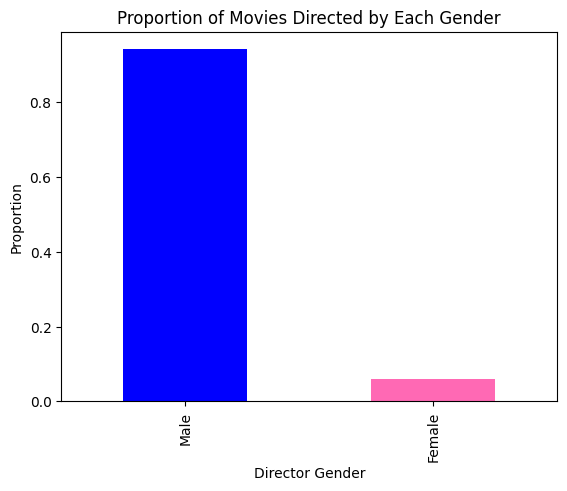

In [29]:
# Proportion of movies in dataset directed by each gender
gender_labels = merged_df['gender'].map({1: 'Male', 0: 'Female'})
props = gender_labels.value_counts() / gender_labels.value_counts().sum()

# Create plot
colors = ['blue', '#FF69B4']
plot = props.plot(kind='bar', color=colors)
plt.xlabel('Director Gender')
plt.ylabel('Proportion')
plt.title('Proportion of Movies Directed by Each Gender')

plt.show()

While it is important to acknowledge the strong class imbalance within the dataset, training a basic linear regression model to predict movie ratings did not reveal a substantial discrepancy in accuracy between male-directed and female-directed movies. 

In [30]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# Select common features
common_features = ['year', 'documentary', 'romance', 'fantasy', 'western', 'thriller',
            'childrens', 'film_noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 'action', 'mystery', 'war', 'musical', 'animation', 'sci_fi', 'male_director_proportion', 'all_male_director']

# Filter data for fully male directed movies separately
df_male_director = Ratings_and_Movies[Ratings_and_Movies['all_male_director'] == 1]
df_female_director = Ratings_and_Movies[Ratings_and_Movies['all_male_director'] == 0]

# Function to train and evaluate a model
def train_and_evaluate(data, director_gender):
    X = data[common_features]
    y = data['user_rating']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate MSE for the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for {director_gender}: {mse}')

# Train and evaluate different models for entirely male directed movies vs movies featuring female director(s)
train_and_evaluate(df_male_director, 'Movies with all Male Directors')
train_and_evaluate(df_female_director, 'Movies with Female Director(s)')

Mean Squared Error for Movies with all Male Directors: 1.1667957768224575
Mean Squared Error for Movies with Female Director(s): 1.1397977798088128


The model demonstrated comparable performance in predicting ratings for both director genders. The mean squared error (MSE) for predicting ratings of female-directed movies was only slightly lower than that for male-directed movies, indicating no significant difference in MSE between the different director genders.

Because of this similar performance in MSE across director genders, plus the time-constraints of the project and limited resources, we decide not to correct the class imbalance. This imbalance does not significantly impact the predictive capabilities of the linear regression model.

Our model utilizes features such as the genre of the movie and year to determine whether a user is likely to give that movie a high rating, based on their previous ratings for movies of similar features. So, we examine the distribution of how movie genres and years compare across the different director genders.

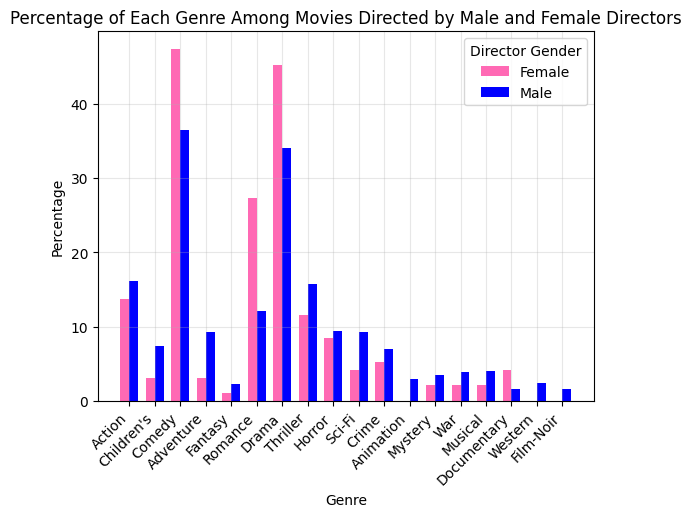

In [31]:
# Sum of genre columns for each director gender
genre_counts_by_gender = merged_df.groupby('gender')[['Action', "Children's", 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Thriller', 'Horror', 'Sci-Fi', 'Crime', 'Animation', 'Mystery', 'War', 'Musical', 'Documentary', 'Western', 'Film-Noir']].sum()

# Total movies by each director gender to normalize sum above
total_movies_by_gender = merged_df['gender'].value_counts()
genre_percentage_by_gender = genre_counts_by_gender.div(total_movies_by_gender, axis=0) * 100

# Create plot and legend
bar_width = 0.35
index = np.arange(len(genre_percentage_by_gender.columns))
female_data = genre_percentage_by_gender.loc[0.0]
male_data = genre_percentage_by_gender.loc[1.0]
plt.bar(index, female_data, bar_width, label='Female', color='#FF69B4')
plt.bar(index + bar_width, male_data, bar_width, label='Male', color='blue')
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.title('Percentage of Each Genre Among Movies Directed by Male and Female Directors')
plt.xticks(index + bar_width / 2, genre_percentage_by_gender.columns, rotation=45, ha='right')
plt.legend(title='Director Gender')
plt.grid(alpha=0.3)
plt.show()

Certain genres, such as Animation and Western, are dominated by male directors. Users who predominantly rate movies within these genres are likely to receive higher predicted ratings for entirely-male directed movies due to the disproportionate representation of male directors.

Although we saw earlier that the utility is comparable across the different director genders (calculated through MSE), we now look into fairness. We know that the model does not perform significantly better for male directors versus female directors, but as seen in the rating breakdown by director gender, we are inclined to believe that entirely-male directed movies receive higher predictions for a perfect rating of 5.

## Checking for Bias

#### Remove Non-numerical Column (Title) to Make Dataset Compatible with AIF360

We remove the movie title because it is not relevant to our model, and for now, we can reference the movie ID instead.

In [32]:
Ratings_and_Movies = Ratings_and_Movies.drop('title', axis=1)

In our model, we designate a perfect rating of 5 as the favorable outcome, since we believe that entirely-male directed movies receive higher predictions for a perfect rating of 5. Given the societal context of gender disparities, we acknowledge entirely-male directed movies as the privileged group within our analysis.

In [33]:
# Define the protected attributes as gender breakdown of directors
protected_attributes = ['all_male_director']

# Define a perfect rating of 5 as the favorable class
favorable_classes = [5]

# Create a StandardDataset
dataset = StandardDataset(Ratings_and_Movies, label_name='user_rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[[1]])  # Only one class for all_male_director (e.g., male is privileged)

# Calculate the disparate impact and statistical parity difference of the dataset before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'all_male_director': 0}],
                                         privileged_groups=[{'all_male_director': 1}])
print("Disparate Impact Before Mitigation:", metric_before.disparate_impact())
print("Statistical Parity Difference Before Mitigation:", metric_before.statistical_parity_difference())

Disparate Impact Before Mitigation: 0.6936795435950334
Statistical Parity Difference Before Mitigation: -0.06810877956209874


#### Disparate Impact:
- The 3/4ths rule is a standard threshold used for disparate impact analysis. According to this rule, if the favorable outcome rate for a group is less than 75% (since the fraction 3/4 maps to a percentage of 75%), bias is present in the dataset.
- Our Disparate Impact value of 0.6936795435950334 maps to a percentage of ~69%, which is less than 75%. Movies with female directors are getting 5-star ratings about 69% as often as fully male-directed movies. Since this is less than 75%, there is a bias in how 5-star ratings are distributed between the different gender breakdowns of the movie directors.
- There is an imbalance in the favorable outcome (perfect rating of 5) between male and female directors within the dataset. Fully male-directed movies, as the privileged group, are more likely to achieve the favorable outcome compared to movies with female directors.

#### Statistical Parity:
- A Statistical Parity Difference close of 0 shows no difference in the proportion of favorable outcomes between different groups. Our value is close to 0 and does not show a discernible bias.
- Our Statistical Parity Difference value of -0.06810877956209874 (before mitigation) indicates a tiny difference in the proportion of favorable outcomes (perfect ratings of 5) between fully-male directed movies and movies with female directors. The negative value suggests that movies with female directors experience a lower rate of favorable outcomes compared to fully-male directed movies, implying that fully male-directed movies receive a higher proportion of 5-star ratings than female-directed movies.

While the Statistical Parity Difference does not notably capture bias, the Disparate Impact is able to show a strong indication of bias based on the director gender. By looking at both metrics, we can better understand how gender bias is present in our dataset and take the appropriate mitigation measures to work towards a more fair model.

### [3.](#Table-of-Contents) Model Development & Evaluation

Due to AIF360's bias mitigation techniques being optimized for classification and regression tasks, we first examine bias mitigation in our dataset on a classifier model. This enables us to evaluate the efficacy of bias mitigation techniques within a classifier before extrapolating these insights to recommender systems.

#### Random Forest (Classification Algorithm)
We use a Random Forest Classifier to predict whether a user will give a movie a perfect rating (5 stars) based on various movie attributes, including the year of release, genre, male_director_proportion, and whether or not the movie is entirely-male directed. We include the variable 'male_director_proportion' since it helps increase utility.

We develop the model using training and testing data. In addition, we calculate the fairness metrics of Disparate Impact and Statistical Parity Difference on the model as well as model utility through accuracy.

In [34]:
# Define features and target variable
X = Ratings_and_Movies[['year', 'documentary', 'romance', 'fantasy', 'western', 'thriller',
                         'childrens', 'film_noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 
                         'action', 'mystery', 'war', 'musical', 'animation', 'sci_fi', 'male_director_proportion', 'all_male_director']]
y = (Ratings_and_Movies['user_rating'] == 5).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=0.2, random_state=42)

# Define the protected attribute as director gender breakdown
protected_attributes = ['all_male_director']

# Define the privileged group as entirely-male directed movies, and unprivileged group as movies with at least one female director 
privileged_groups = [{'all_male_director': 1}]
unprivileged_groups = [{'all_male_director': 0}]

# Initialize the Random Forest Classifier model with n_estimators=100
rf_classifier_before = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the original classifier on the original dataset
rf_classifier_before.fit(X_train, y_train)

# Make predictions on the test data using the original model
y_pred_rf_before = rf_classifier_before.predict(X_test)

# Calculate accuracy on the original dataset
accuracy_rf_before = accuracy_score(y_test, y_pred_rf_before)

# Dataframe with X_test, y_test, and y_pred_rf_before
test_results_before = pd.concat([X_test, pd.DataFrame({'user_rating': y_test, 'predicted_rating': y_pred_rf_before})], axis=1)

# Protected attribute from the original dataset
test_results_before['all_male_director'] = Ratings_and_Movies.loc[X_test.index, 'all_male_director']

# Create StandardDataset
dataset_before = StandardDataset(df=test_results_before,
                                  label_name='user_rating', favorable_classes=[1],
                                  protected_attribute_names=protected_attributes,
                                  privileged_classes=[[1]])

# Create BinaryLabelDatasetMetric to assess bias on the dataset
dataset_metric_before = BinaryLabelDatasetMetric(dataset_before, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Bias metrics before reweighing
display(Markdown("#### Bias Metrics before Reweighing"))
print("Disparate Impact:", dataset_metric_before.disparate_impact())
print("Statistical Parity Difference:", dataset_metric_before.statistical_parity_difference())

# Accuracy before reweighing on the raw dataset
display(Markdown("#### Accuracy before Reweighing on Raw Data"))
print("n_estimators:", rf_classifier_before.n_estimators)
print("Accuracy before Reweighing on Raw Data:", accuracy_rf_before)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_before))

results_dict = {
    'Algorithm': ['Random Forest Classifier'],
    'Disparate Impact Before': [dataset_metric_before.disparate_impact()],
    'Disparate Impact After': [None], 
    'Statistical Parity Difference Before': [dataset_metric_before.statistical_parity_difference()],
    'Statistical Parity Difference After': [None], 
    'Accuracy Before': [accuracy_rf_before],
    'Accuracy After': [None], 
    'RMSE Before': [None],  
    'RMSE After': [None], 
    'MAE Before': [None], 
    'MAE After': [None]  
}

# Create a DataFrame from the dictionary
results_table = pd.DataFrame(results_dict)

#### Bias Metrics before Reweighing

Disparate Impact: 0.66751005405058
Statistical Parity Difference: -0.07432062114365237


#### Accuracy before Reweighing on Raw Data

n_estimators: 100
Accuracy before Reweighing on Raw Data: 0.7866022619775142

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88     93272
           1       0.56      0.12      0.19     26181

    accuracy                           0.79    119453
   macro avg       0.68      0.55      0.53    119453
weighted avg       0.75      0.79      0.73    119453



Utility:
- Precision is the ratio of correctly predicted positive observations to the total predicted positives. Precision measures how many of the predicted positive instances are actually positive.
   - Precision for class 0 (the user's rating is not equal to 5) is 0.80, indicating that among the instances predicted as not having a user rating of 5, 80% were correct.
  - Precision for class 1 (the user's rating is equal to 5) is 0.56, indicating that among the instances predicted as having a user rating of 5, 56% were correct.

- Recall (Sensitivity or True Positive Rate) is the ratio of correctly predicted positive observations to the all observations in the actual class. Recall measures how many actual positive instances were captured by the model.
   - The recall for class 0 is 0.97, meaning that the model identified 97% of instances with a user rating not equal to 5.
   - The recall for class 1 is 0.12, meaning that the model identified only 12% of instances with a user rating equal to 5.

- The F1-score is the weighted average of precision and recall, almost like a balance of precision and recall. It ranges from 0 to 1, with higher values indicating a better balance.
  - The F1-score for class is 0 is 0.88, and the F1-score for class 1 is 0.19.
  - Since the F1-score for class is 0 is higher, class 0 holds a better balance.

- The Support is the number of actual occurrences of that class in the dataset.

Bias Metrics:
- Our Disparate Impact of 0.66751005405058 suggests that the unprivileged group is at a disadvantage compared to the privileged group, as they are less likely to receive favorable outcomes.
- Our Statistical Parity Difference of -0.07432062114365237 is not a strong indicator of bias due to this value being close to 0. 

Although the model achieves a fairly high accuracy of 0.7866022619775142, the lower recall for class 1 suggests that it might have difficulty correctly identifying instances with a user rating equal to 5. In the context of ethical biases, the disparate impact indicates that movies with at least one female director (i.e., not entirely-male directed) are less likely to receive the favorable outcome of a 5 star rating.

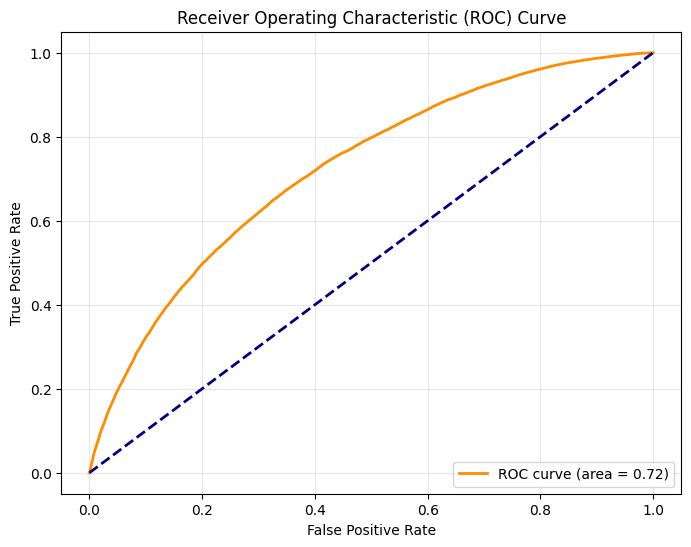

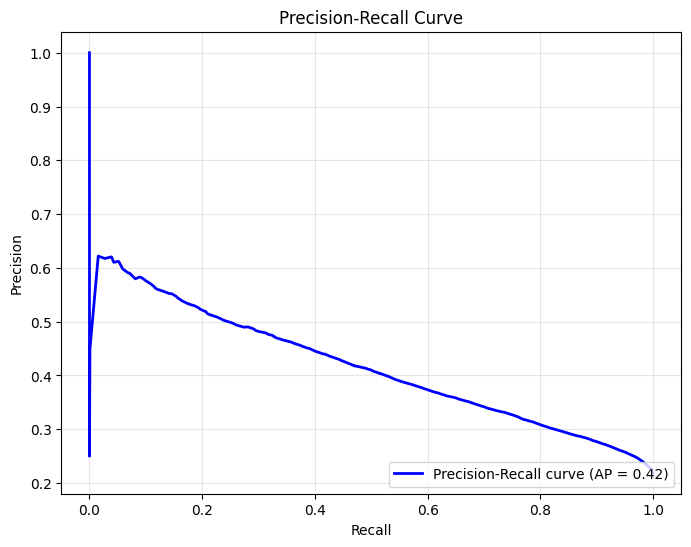

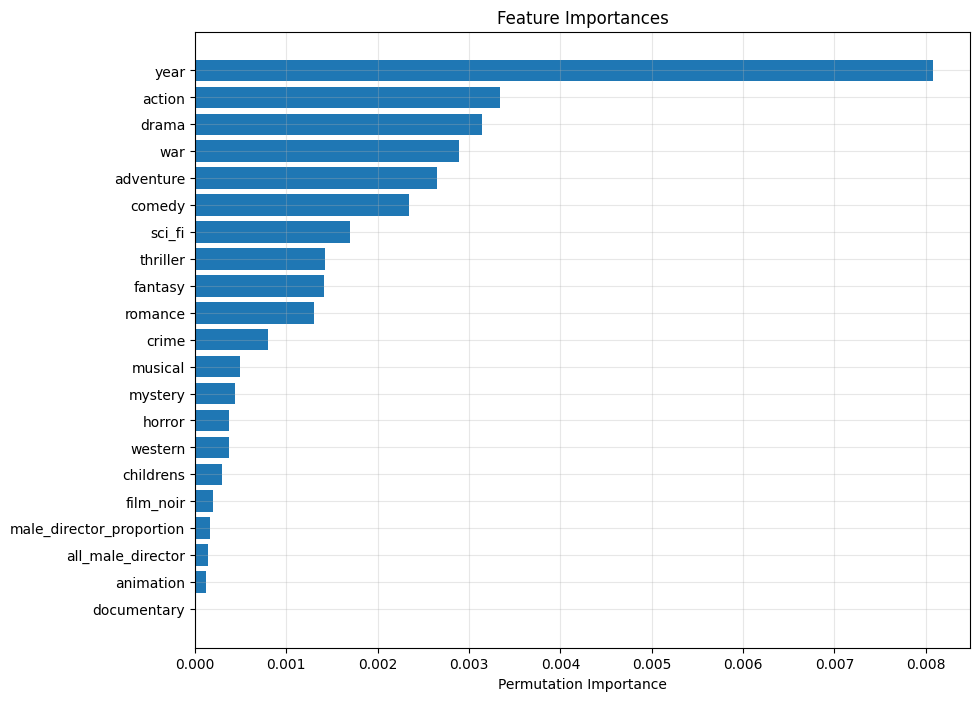

In [35]:
# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, rf_classifier_before.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Create plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, rf_classifier_before.predict_proba(X_test)[:, 1])
average_precision = average_precision_score(y_test, rf_classifier_before.predict_proba(X_test)[:, 1])

# Create plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Feature Importances
result = permutation_importance(rf_classifier_before, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

# Create plot
plt.figure(figsize=(10, 8))
plt.barh(range(X_test.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importances')
plt.grid(alpha=0.3)
plt.show()

The ROC-AUC Curve visualizes the trade-off between true positive and false positive rates.
- The ROC-AUC score ranges from 0 to 1.
- An AUC of 0.72 suggests a moderate discriminatory power of our model.
- A higher ROC-AUC indicates better separation between the positive and negative classes. A typical rule of thumb for interpretation maps the following values:
  - 0.5-0.6: Poor
  - 0.6-0.7: Fair
  - 0.7-0.8: Good
  - 0.8-0.9: Very good
  - 0.9-1.0: Excellent

The Precision-Recall Curve shows the precision-recall trade-off, which is often useful for imbalanced datasets.
- The Precision-Recall AUC score also ranges from 0 to 1.
- An AP of 0.42 suggests that the precision-recall trade-off is not very high.
- Precision-Recall AUC is particularly useful when dealing with imbalanced datasets, focusing on the positive class.

The Feature Importances Bar Plot displays the importance of each feature in the trained Random Forest classifier model. The most important feature when predicting rating was the year the movie was released.

#### Recommender Systems
We now develop several recommender systems using various similarity metrics and matrix calculations. Further information on the particular metric and calculations used can be found in the specific section on each model. Mathematical formulas for each similarity metric can be found in the definitions section of the report.

#### Recommender System using Jaccard Similarity
In this recommender system, a Movie-User matrix is created based on user ratings. The recommendation algorithm relies on Jaccard Similarity between movies to generate personalized recommendations for a user.

The generate_movie_recommendations function identifies movies already rated by the user and calculates Jaccard similarity with other movies, considering user preferences. The resulting recommendations are then filtered and ranked by Jaccard similarity.

In [36]:
# Create a Movie-User matrix
movie_user_matrix = Ratings_and_Movies.pivot_table(index='movie_id', columns='user_id', values='user_rating', fill_value=0)

# Function to calculate Jaccard similarity between two movies
def calculate_jaccard_similarity(movie1, movie2):
    intersection = sum((movie1 > 0) & (movie2 > 0))
    union = sum((movie1 > 0) | (movie2 > 0))
    
    if union == 0:
        return 0
    
    return intersection / union

# Function to generate movie recommendations based on Jaccard similarity
def generate_movie_recommendations(user_id, movie_user_matrix, df_movies, top_n=10):
    
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movie_id'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_jaccard_similarity(target_movie_ratings, x), axis=1)
    
        # Sort movies by Jaccard similarity in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Add recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename column to 'Jaccard_Score'
    recommendations = recommendations.rename(columns={0: 'Jaccard_Similarity'})
    
    return recommendations

To examine patterns in the director gender breakdown of recommended movies, we look at the recommendations for several different users. We start with looking at the top 10 movies recommended for User 1.

#### Plotted director gender proportion based on user's watch history

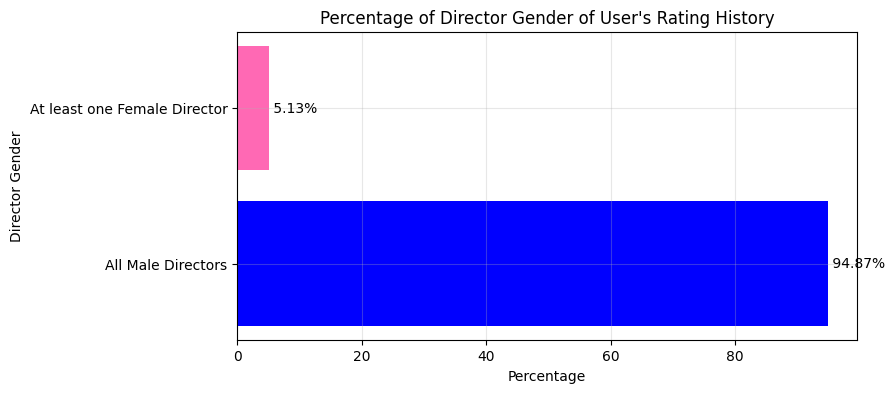

In [37]:
# Example: Recommend top 10 movies for User ID 1
user_id_to_recommend = 1

# Proportion of entirely-male directed movies for the user's rating history
all_male_director_proportion = Ratings_and_Movies[Ratings_and_Movies['user_id'] == user_id_to_recommend]['all_male_director'].mean() * 100

# Proportion of movies with female directors
female_director_proportion = 100 - all_male_director_proportion

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title("Percentage of Director Gender of User's Rating History")
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{proportion: .2f}%', va='center')
plt.grid(alpha=0.3)
plt.show()

#### Find top 10 movies for any given user ID

In [38]:
recommended_movies = generate_movie_recommendations(user_id_to_recommend, movie_user_matrix, Ratings_and_Movies[['movie_id']], top_n=10)

print(f"Top 10 Recommended Movies for User ID {user_id_to_recommend}:\n", recommended_movies)

Top 10 Recommended Movies for User ID 1:
   movie_id  Jaccard_Similarity
0     1265            0.459450
1      356            0.403549
2     1580            0.394260
3     2396            0.382033
4     1196            0.379151
5     1923            0.370974
6     1198            0.363528
7      589            0.360783
8      296            0.360666
9     2716            0.359949


#### Plotted director gender proportion of top 10 movies recommended to user

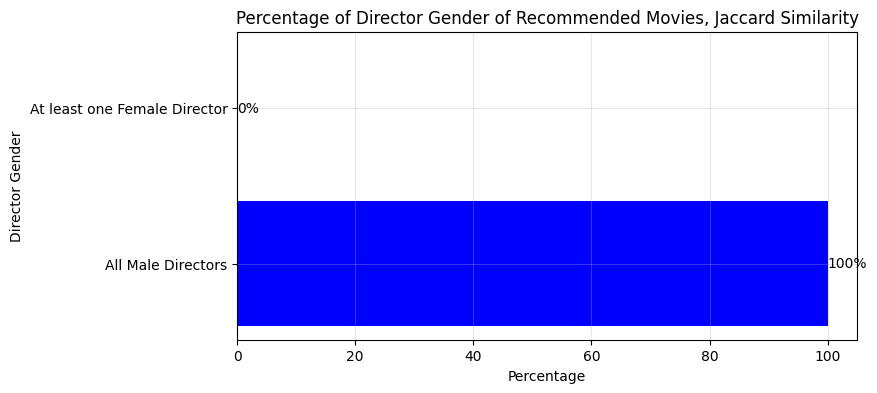

In [39]:
# Proportion of recommended movies that are entirely-male directed
all_male_director_proportion = merged_df[merged_df['MovieID'].isin(list(recommended_movies['movie_id']))]['all_male_director'].mean() * 100

# Proportion of movies with female directors
female_director_proportion = 100 - all_male_director_proportion

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Director Gender of Recommended Movies, Jaccard Similarity')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

The top 10 recommended movies do not appear to provide diverse suggestions for User 1. All the recommended movies are entirely male-directed, introducing bias and overlooking potentially good recommendations directed by females. Approximately 5% of User 1's rating history included at least one female director. It is crucial to understand why solely male-directed movies are being recommended, as director gender should not be a factor in detracting recommendations.

#### Recommender System using Cosine Similarity

We investigate whether recommender systems using different similarity measures are able to provide more diverse recommendations. We look at Cosine Similarity, a popular measure for capturing nuanced relationships between items and users, particularly in high-dimensional spaces.

Cosine similarity evaluates the similarity between movies based on the cosine of the angle between their respective feature vectors, representing user ratings. The higher the cosine similarity value, the more alike two movies are considered to be in terms of user ratings.

To generate movie recommendations for a given user using Cosine similarity, the model takes the unique user ID, a matrix representing user-movie ratings, the movie information, and the desired number of top recommendations (top_n). It first identifies movies already rated by the user, then computes the similarity between each of these rated movies and all other movies in the dataset. Based on the Cosine similarity scores, it selects the top N movies as recommendations, excluding those already rated by the user.

In [40]:
# Function to calculate Cosine similarity between two movies
def calculate_cosine_similarity(movie1, movie2):
    return cosine_similarity([movie1], [movie2])[0][0]

# Function to generate movie recommendations based on Cosine similarity
def generate_movie_recommendations_cosine(user_id, movie_user_matrix, df_movies, top_n=10):
    
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movie_id'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_cosine_similarity(target_movie_ratings, x), axis=1)
    
        # Sort movies by Cosine similarity in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Add recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename column to 'Cosine_Similarity'
    recommendations = recommendations.rename(columns={0: 'Cosine_Similarity'})
    
    return recommendations

# Example for User 1
user_id_to_recommend = 1
top_recommendations_cosine = generate_movie_recommendations_cosine(user_id_to_recommend, movie_user_matrix, Ratings_and_Movies[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Cosine) for User ID {user_id_to_recommend}:\n", top_recommendations_cosine)

Top 10 Recommended Movies (Cosine) for User ID 1:
   movie_id  Cosine_Similarity
0     1265           0.610826
1     1196           0.552856
2     1580           0.552362
3      356           0.551034
4     2396           0.533700
5     1198           0.530881
6     1923           0.523675
7     1210           0.521209
8     2716           0.519305
9      589           0.515537


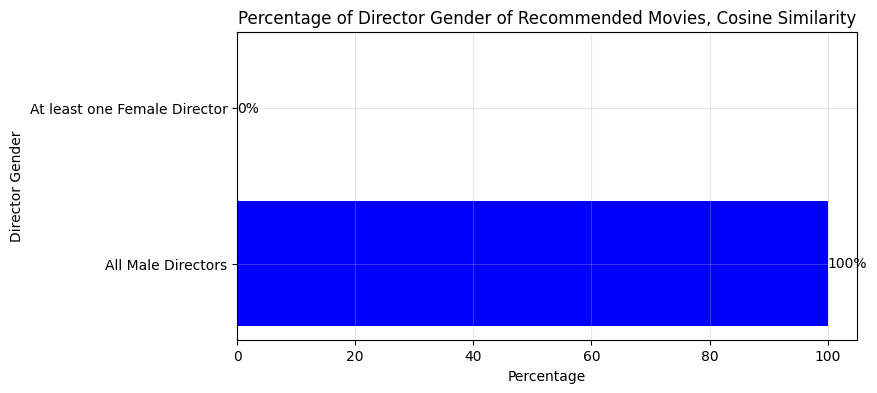

In [41]:
# Calculate proportion of recommended movies that are entirely-male directed
all_male_director_proportion_cosine = merged_df[merged_df['MovieID'].isin(list(top_recommendations_cosine['movie_id']))]['all_male_director'].mean() * 100

# Calculate proportion of recommended movies with female directors
female_director_proportion_cosine = 100 - all_male_director_proportion_cosine

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion_cosine, female_director_proportion_cosine]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Director Gender of Recommended Movies, Cosine Similarity')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

The recommender system using Cosine Similarity exhibited the same behavior in the diversity of director genders of recommended movies. Each of the top 10 movie recommendations are fully directed by males.

#### Recommender System using Pearson Correlation

Pearson correlation is a different metric that is often used to capture linear relationships between variables.

This approach measures the linear correlation between two movies based on the ratings provided by users. A higher Pearson correlation indicates greater similarity in user ratings between two movies. It first identifies the common users who have rated both movies, then computes the correlation coefficient based on their ratings. If there are no common users, the correlation is considered to be zero.

The recommender system identifies movies already rated by the user, computes the Pearson correlation between each of these rated movies and all other movies in the dataset, and selects the top N movies with the highest correlation to reccomend, excluding those already rated by the user.

In [42]:
# Function to calculate Pearson correlation between two movies
def calculate_pearson_correlation(movie1, movie2):
    common_users = movie1.index.intersection(movie2.index)
    
    if len(common_users) == 0:
        return 0
    
    rating1 = movie1[common_users]
    rating2 = movie2[common_users]
    
    correlation, _ = pearsonr(rating1, rating2)
    return correlation

# Function to generate movie recommendations based on Pearson correlation
def generate_movie_recommendations_pearson(user_id, movie_user_matrix, df_movies, top_n=10):
    
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movie_id'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_pearson_correlation(target_movie_ratings, x), axis=1)
    
        # Sort movies by Pearson correlation in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Add recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename column to 'Pearson_Correlation'
    recommendations = recommendations.rename(columns={0: 'Pearson_Correlation'})
    
    return recommendations

# Example for User 1
user_id_to_recommend = 1
top_recommendations_pearson = generate_movie_recommendations_pearson(user_id_to_recommend, movie_user_matrix, Ratings_and_Movies[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Pearson) for User ID {user_id_to_recommend}:\n", top_recommendations_pearson)

Top 10 Recommended Movies (Pearson) for User ID 1:
   movie_id  Pearson_Correlation
0     1265             0.407547
1     3253             0.370424
2     1923             0.357726
3     1517             0.347186
4       39             0.326788
5     1500             0.325082
6      356             0.323808
7      500             0.308802
8     2174             0.306969
9      586             0.302354


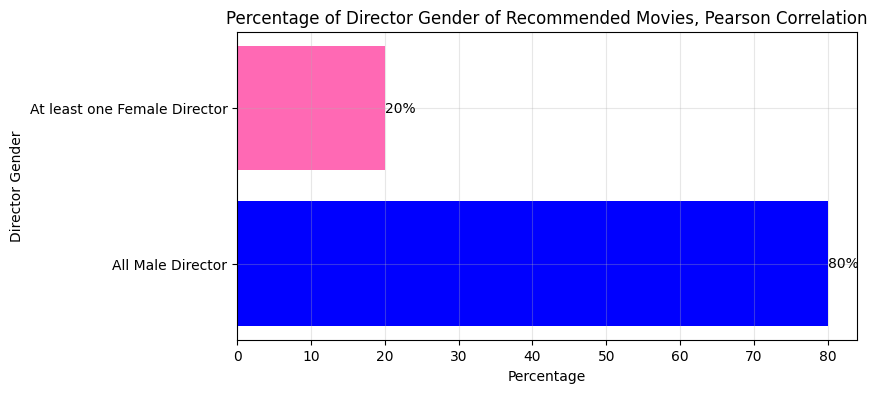

In [43]:
# Calculate proportion of recommended movies that are entirely-male directed
all_male_director_proportion_pearson = merged_df[merged_df['MovieID'].isin(list(top_recommendations_pearson['movie_id']))]['all_male_director'].mean() * 100

# Calculate proportion of recommended movies with female directors
female_director_proportion_pearson = 100 - all_male_director_proportion_pearson

# Create plot
labels = ['All Male Director', 'At least one Female Director']
proportions = [all_male_director_proportion_pearson, female_director_proportion_pearson]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Director Gender of Recommended Movies, Pearson Correlation')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

Recommendations generated by the system using Pearson Correlation exhibited an increase in diversity concerning the gender of movie directors (compared to the Jaccard and Cosine similarity metrics). Specifically, the recommended movies exhibited an average proportion of female directors of 20%, a notable increase compared to the ~5% average observed within the user's watch history.

While the findings for User 1 suggests that recommender systems using Pearson Correlation yield a more inclusive selection of movies, we examine other users to see if this is a typical trend. To determine which user to examine next, we select the user who has rated the greatest proportion of movies with female directors. 

In [44]:
Ratings_and_Movies.groupby('user_id')['all_male_director'].mean().sort_values()

user_id
2908    0.555556
1823    0.750000
5146    0.750000
4282    0.761905
841     0.764706
          ...   
2312    1.000000
2315    1.000000
2326    1.000000
2296    1.000000
3020    1.000000
Name: all_male_director, Length: 6040, dtype: float64

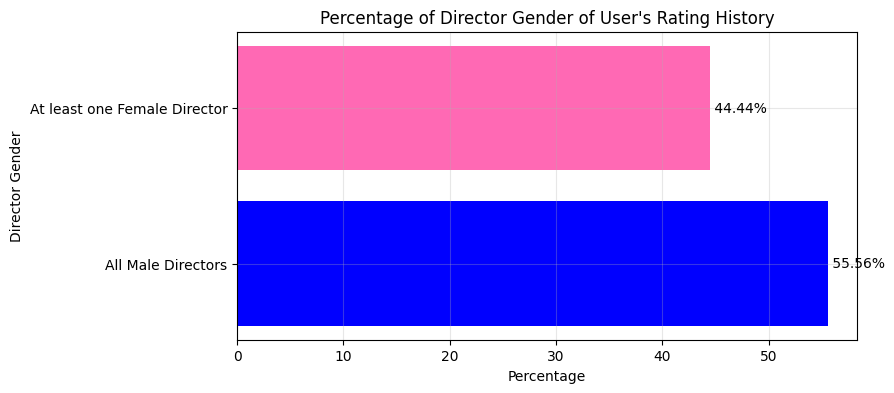

In [45]:
user_id_to_recommend = 2908

# Proportion of entirely-male directed movies for the user's rating history
all_male_director_proportion = Ratings_and_Movies[Ratings_and_Movies['user_id'] == user_id_to_recommend]['all_male_director'].mean() * 100

# Proportion of movies with female directors
female_director_proportion = 100 - all_male_director_proportion

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title("Percentage of Director Gender of User's Rating History")
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{proportion: .2f}%', va='center')
plt.grid(alpha=0.3)
plt.show()

User 2908 had the greatest representation of female directed movies in the dataset, as ~44% of the movies they have rated featured female directors.

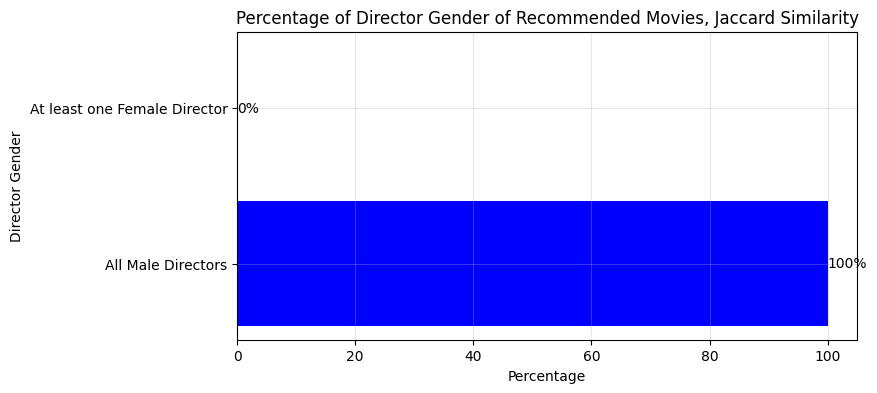

In [46]:
# Find Jaccard recommendations for User ID 2908
recommended_movies = generate_movie_recommendations(user_id_to_recommend, movie_user_matrix, Ratings_and_Movies[['movie_id']], top_n=10)

# Proportion of recommended movies that are entirely-male directed
all_male_director_proportion = merged_df[merged_df['MovieID'].isin(list(recommended_movies['movie_id']))]['all_male_director'].mean() * 100

# Proportion of movies with female directors
female_director_proportion = 100 - all_male_director_proportion

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Director Gender of Recommended Movies, Jaccard Similarity')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

However, the recommender system using Jaccard Similarity had absolutely no movies with female directors. Every movie recommended was entirely male-directed.

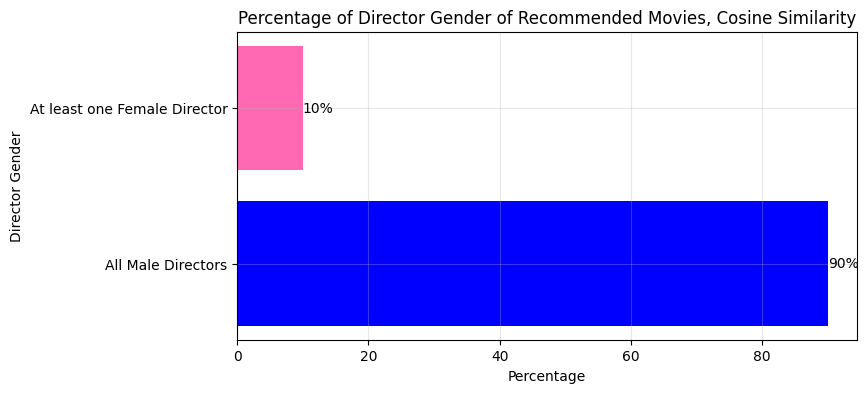

In [47]:
# Find Cosine recommendations for User ID 2908
top_recommendations_cosine = generate_movie_recommendations_cosine(user_id_to_recommend, movie_user_matrix, Ratings_and_Movies[['movie_id']], top_n=10)

# Calculate proportion of recommended movies that are entirely-male directed
all_male_director_proportion_cosine = merged_df[merged_df['MovieID'].isin(list(top_recommendations_cosine['movie_id']))]['all_male_director'].mean() * 100

# Calculate proportion of recommended movies with female directors
female_director_proportion_cosine = 100 - all_male_director_proportion_cosine

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion_cosine, female_director_proportion_cosine]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Director Gender of Recommended Movies, Cosine Similarity')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

The recommended movies using Cosine Similarity were more diverse than the recommended movies using Jaccard Similarity, but still had a lot less movies featuring female directors than User 2908's rating history.

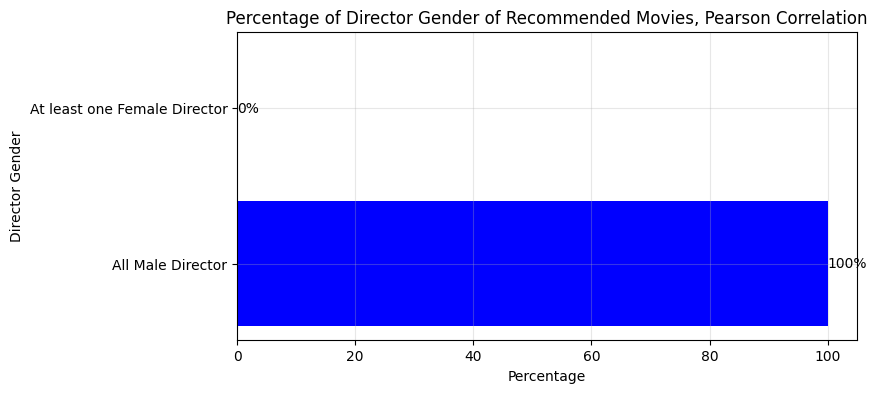

In [48]:
# Find Pearson recommendations for User ID 2908
top_recommendations_pearson = generate_movie_recommendations_pearson(user_id_to_recommend, movie_user_matrix, Ratings_and_Movies[['movie_id']], top_n=10)

# Calculate proportion of recommended movies that are entirely-male directed
all_male_director_proportion_pearson = merged_df[merged_df['MovieID'].isin(list(top_recommendations_pearson['movie_id']))]['all_male_director'].mean() * 100

# Calculate proportion of recommended movies with female directors
female_director_proportion_pearson = 100 - all_male_director_proportion_pearson

# Create plot
labels = ['All Male Director', 'At least one Female Director']
proportions = [all_male_director_proportion_pearson, female_director_proportion_pearson]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Director Gender of Recommended Movies, Pearson Correlation')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

The recommended movies using Pearson Correlation performed the same as Jaccard Similarity with no movies featuring female directors.

For User 1, the recommender system using Pearson Correlation yielded the greatest percentage of female directed movies (20%), whereas it was Cosine Similarity (10%) for User 2908. User 1 received more diverse recommendations even though they had watched less female directed movies than User 2908. It is inconclusive which similarity function yields in the least biased recommendations since it varies per user.

Looking at the movie_user_matrix that the recommender systems use, they only take into account user ID, movie ID, and the user rating. It does not take into account the director's gender, hence why we investigate in the next section whether bias mitigation techniques will work on recommender systems using these similarity metrics.

#### Recommender System using Singular Value Decomposition

From the Surprise machine learning toolkit, Singular Value Decomposition (SVD) is a Matrix Factorization-based algorithm that often captures latent factors underlying user preferences. The recommender model uses an SVD object, which is trained on the training dataset to optimize predictive performance using user-item interactions. Cross-validation is performed to find the best parameters to assess the model's accuracy for predictions.

In [49]:
# Create a Surprise Reader object
reader = Reader(rating_scale=(1, 5))

# Load data to Surprise Dataset
data = Dataset.load_from_df(Ratings_and_Movies[['user_id', 'movie_id', 'user_rating']], reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize SVD algorithm
svd = SVD()

# Train algorithm on training set
svd.fit(trainset)

# Evaluate algorithm using cross-validation
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8808  0.8780  0.8800  0.8773  0.8801  0.8792  0.0013  
MAE (testset)     0.6941  0.6919  0.6927  0.6910  0.6926  0.6925  0.0010  
Fit time          3.47    3.45    3.04    2.93    3.16    3.21    0.22    
Test time         0.67    0.53    0.38    0.42    0.22    0.45    0.15    


{'test_rmse': array([0.88076173, 0.87800581, 0.87999562, 0.87727988, 0.88014815]),
 'test_mae': array([0.69412038, 0.69194994, 0.69266505, 0.69098754, 0.69261286]),
 'fit_time': (3.4653890132904053,
  3.4517509937286377,
  3.036829948425293,
  2.92769718170166,
  3.156780958175659),
 'test_time': (0.6698250770568848,
  0.5347471237182617,
  0.3823740482330322,
  0.41562795639038086,
  0.22297120094299316)}

This algorithm allows us to make predictions for specific movies for users. For example, user 1 is predicted to rate movie ID 302, 4 out of 5 stars.

In [50]:
# Example: Make a prediction for user 1, movie 302
user_id_to_predict = 1
movie_id_to_predict = 302

# Get the prediction
prediction = svd.predict(user_id_to_predict, movie_id_to_predict, 3)

# Round prediction
rounded_prediction = round(prediction.est)

print(f"Prediction for user {user_id_to_predict}, movie {movie_id_to_predict}: {rounded_prediction}")

Prediction for user 1, movie 302: 4


We can make predictions over the user's entire rated movies to assess the model's performance.

In [51]:
user_id_to_predict = 1

# Filter Ratings_and_Movies DataFrame for a specific user
user_ratings = Ratings_and_Movies[Ratings_and_Movies['user_id'] == user_id_to_predict]

# Iterate over user's rated movies and make predictions
for _, row in user_ratings.iterrows():
    movie_id_to_predict = row['movie_id']
    
    # Get prediction
    prediction = svd.predict(user_id_to_predict, movie_id_to_predict, 3)
    
    # Round prediction
    rounded_prediction = round(prediction.est)
    
    print(f"Prediction for user {user_id_to_predict}, movie {movie_id_to_predict}: {rounded_prediction}")

Prediction for user 1, movie 1: 5
Prediction for user 1, movie 48: 4
Prediction for user 1, movie 150: 5
Prediction for user 1, movie 260: 5
Prediction for user 1, movie 527: 5
Prediction for user 1, movie 588: 4
Prediction for user 1, movie 594: 4
Prediction for user 1, movie 595: 4
Prediction for user 1, movie 661: 4
Prediction for user 1, movie 914: 5
Prediction for user 1, movie 938: 4
Prediction for user 1, movie 1022: 4
Prediction for user 1, movie 1028: 5
Prediction for user 1, movie 1029: 4
Prediction for user 1, movie 1097: 4
Prediction for user 1, movie 1193: 5
Prediction for user 1, movie 1207: 5
Prediction for user 1, movie 1246: 4
Prediction for user 1, movie 1270: 4
Prediction for user 1, movie 1287: 5
Prediction for user 1, movie 1566: 4
Prediction for user 1, movie 1721: 4
Prediction for user 1, movie 1907: 4
Prediction for user 1, movie 1961: 5
Prediction for user 1, movie 1962: 4
Prediction for user 1, movie 2018: 4
Prediction for user 1, movie 2028: 5
Prediction for 

To assess the predictive accuracy and generalization capability of the model, we use cross-validation. We perform k-fold cross-validation, with k set to 5 for robustness.

The model's performance is evaluated using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). These metrics provide insights into the model's ability to accurately predict user ratings and its overall performance across different folds of the dataset.

RMSE tends to penalize large errors more than smaller ones due to the squaring operation. It is useful for comparing models and understanding the spread of errors, but it is not very intuitive for human interpretation.

MAE, on the other hand, provides a more straightforward and human-friendly interpretation. It represents the average magnitude of errors without considering their direction (i.e., whether they are overestimations or underestimations). In other words, MAE gives the average absolute error, making it easier to understand/interpret in real-world terms. For example, if the MAE is 5, it means, on average, that the model's predictions are off by 5 units from the actual values.

In [52]:
# Get all unique user IDs
all_user_ids = Ratings_and_Movies['user_id'].unique()

# List to store predictions
all_predictions = []

# Iterate through all user IDs and make predictions for all movies
for user_id_to_predict in all_user_ids:
    all_movie_ids = Ratings_and_Movies['movie_id'].unique()
    predictions = [(user_id_to_predict, movie_id, svd.predict(user_id_to_predict, movie_id).est) for movie_id in all_movie_ids]
    all_predictions.extend(predictions)

# Create DataFrame from all predictions and round predicted rating
predictions_df = pd.DataFrame(all_predictions, columns=['user_id', 'movie_id', 'predicted_rating'])
predictions_df['predicted_rating'] = predictions_df['predicted_rating'].round()

# Include original 'all_male_director' column from Ratings_and_Movies DataFrame
predictions_df = pd.merge(predictions_df, Ratings_and_Movies[['user_id', 'movie_id', 'all_male_director']], on=['user_id', 'movie_id'])

print(predictions_df)

# Define protected attributes
protected_attributes = ['all_male_director']

# Define favorable classes as perfect rating of 5 stars
favorable_classes = [5]


movies_aif360_dataset = StandardDataset(Ratings_and_Movies,
                                 label_name='user_rating',
                                 favorable_classes=favorable_classes,
                                 protected_attribute_names=protected_attributes,
                                 privileged_classes=[[1]])

# Calculate fairness metrics before mitigation on dataset
movies_metric_before = BinaryLabelDatasetMetric(movies_aif360_dataset, unprivileged_groups=[{'all_male_director': 0}],
                                         privileged_groups=[{'all_male_director': 1}])
movies_disparate_impact_before = movies_metric_before.disparate_impact()

print("Disparate Impact for Ratings_and_Movies DF Before Mitigation:", movies_disparate_impact_before)
print("Statistical Parity Difference for Ratings_and_Movies DF Before Mitigation:", movies_metric_before.statistical_parity_difference())

# Create StandardDataset
aif360_dataset = StandardDataset(predictions_df, label_name='predicted_rating', favorable_classes=favorable_classes,
                                  protected_attribute_names=protected_attributes,
                                  privileged_classes=[[1]])

# Calculate fairness metrics before mitigation on predictions
metric_before = BinaryLabelDatasetMetric(aif360_dataset, unprivileged_groups=[{'all_male_director': 0}],
                                         privileged_groups=[{'all_male_director': 1}])
print("Disparate Impact on Predictions DF Before Mitigation:", metric_before.disparate_impact())
print("Statistical Parity Difference on Predictions DF Before Mitigation:", metric_before.statistical_parity_difference())

        user_id  movie_id  predicted_rating  all_male_director
0             1         1               5.0                1.0
1             1        48               4.0                1.0
2             1       150               5.0                1.0
3             1       260               5.0                1.0
4             1       527               5.0                1.0
...         ...       ...               ...                ...
597259      745      3915               2.0                0.0
597260      745      3916               2.0                1.0
597261      745      3946               2.0                1.0
597262      745      3948               3.0                1.0
597263      745      3950               2.0                1.0

[597264 rows x 4 columns]
Disparate Impact for Ratings_and_Movies DF Before Mitigation: 0.6936795435950334
Statistical Parity Difference for Ratings_and_Movies DF Before Mitigation: -0.06810877956209874
Disparate Impact on Predictions DF Befor

In [53]:
# Make predictions on test set
predictions = svd.test(testset)

# RMSE (Root Mean Squared Error) of test set
rmse_before = accuracy.rmse(predictions)
print("RMSE Before Mitigation:", rmse_before)

# MAE (Mean Absolute Error) of test set
mae_before = accuracy.mae(predictions)
print("MAE Before Mitigation:", mae_before)

# Store results in table
results_dict = {
    'Algorithm': ['SVD'],
    'Disparate Impact Before': [metric_before.disparate_impact()],
    'Disparate Impact After': [None],  
    'Statistical Parity Difference Before': [metric_before.statistical_parity_difference()],
    'Statistical Parity Difference After': [None],  
    'Accuracy Before': [None],
    'Accuracy After': [None],  
    'RMSE Before': [rmse_before], 
    'RMSE After': [None],  
    'MAE Before': [mae_before], 
    'MAE After': [None] 
}
results_table = pd.concat([results_table, pd.DataFrame(results_dict)], ignore_index=True)

RMSE: 0.7146
RMSE Before Mitigation: 0.7146405963914735
MAE:  0.5605
MAE Before Mitigation: 0.5604532156766929


Bias metrics:
- Disparate Impact Before Mitigation: 0.3693759561648962
    - Our value indicates a significant disparity in favorable outcomes between movies directed by males and those directed by females, suggesting unequal representation in the predicted ratings (recommended) items.

- Statistical Parity Difference Before Mitigation: -0.05460790391117668
    - Our value does not significantly indicate a bias favoring movies directed by females in receiving favorable outcomes.

Utility:
- RMSE (Root Mean Squared Error) Before Mitigation: 0.7146405963914735
    - Our RMSE value signifies the average discrepancy between predicted and actual ratings, reflecting the prediction accuracy of the model in prioritizing entirely-male directed content.

- MAE (Mean Absolute Error) Before Mitigation: 0.5604532156766929
    - The model's average deviation from actual ratings is approximately 0.56 units, allowing insight into prediction accuracy without considering the direction of errors.

#### Making recommendations for user 1 and user 2908 given predictions
Here we want to recommend movies that we predict the user will give 5 stars

In [54]:
user_1_pred = predictions_df[(predictions_df['user_id'] == 1) & (predictions_df['predicted_rating'] == 5)]
user_1_pred

,user_id,movie_id,predicted_rating,all_male_director
0,1,1,5.0,1.0
2,1,150,5.0,1.0
3,1,260,5.0,1.0
4,1,527,5.0,1.0
9,1,914,5.0,1.0
12,1,1028,5.0,1.0
15,1,1193,5.0,1.0
16,1,1207,5.0,1.0
19,1,1287,5.0,1.0
23,1,1961,5.0,1.0


Here, we observe that our model does not recommend any movies directed by females. This is because no movies directed by females were given a 5-star prediction in our SVD algorithm for this user. We would need to analyze more users to get a better picture of bias in our model's recommendations, but for now, we can observe that there is room for bias mitigation. It is also vital to note that this user's watch history only includes 5% female-directed movies.

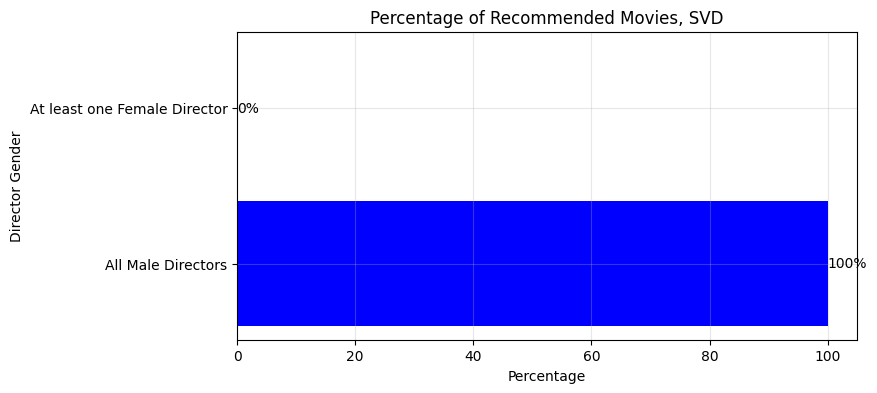

In [55]:
# Calculate proportion of entirely-male directed movies in recommendations
all_male_director_proportion = merged_df[merged_df['MovieID'].isin(list(user_1_pred['movie_id']))]['all_male_director'].mean() * 100

# Calculate the proportion of movies with female directors
female_director_proportion = 100 - all_male_director_proportion

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Recommended Movies, SVD')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

Now, let's consider a user with a more balanced watch history in terms of director gender: user 2908.
- Note, if no 5-star predictions are available, then we would recommend 4-star rated movies to the user based on our predicted ratings from SVD. For a more precise recommendation, we believe that it would also be a good idea to suggest movies where the predicted rating is not rounded. For example, we would have predicted value ratings like 4.9, 4.8, etc., and would only recommend the top 10 highest-rated movies to users. This would be valuable since it would allow us to prioritize recommendations. But for now, we will continue recommending movies that our SVD algorithm rated as 5 stars for this user.
- User 2908 only rated a couple movies 5 stars but given that predictions are variable and subject to change each time the SVD model is created, User 2908 may not receive any predicted ratings of 5-stars. Hence, the conditional to recommend the next top few ratings of 4-stars.

In [56]:
user_2908_pred = predictions_df[(predictions_df['user_id'] == 2908) & (predictions_df['predicted_rating'] == 5)]
if (len(user_2908_pred) < 1):
    user_2908_pred = predictions_df[(predictions_df['user_id'] == 2908) & (predictions_df['predicted_rating'] == 4)]

user_2908_pred

,user_id,movie_id,predicted_rating,all_male_director
592422,2908,1219,5.0,1.0


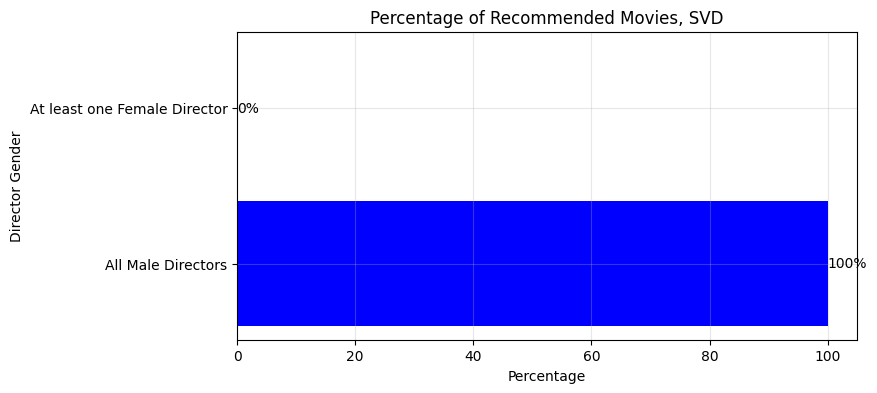

In [57]:
# Calculate proportion of entirely-male directed movies in recommendations
all_male_director_proportion = merged_df[merged_df['MovieID'].isin(list(user_2908_pred['movie_id']))]['all_male_director'].mean() * 100

# Calculate the proportion of movies with female directors
female_director_proportion = 100 - all_male_director_proportion

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Recommended Movies, SVD')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

Here, we can also observe that our model does not recommend any movies directed by females. Initially, we expected that this user would be given fairer recommendations, considering that their watch history includes 44% female-directed movies. However, when considering that SVD tries to predict ratings based on how other users have predicted the movie, we can see that bias from various users can influence what is recommended to other users, as seen with user 2908's diverse watch history, ultimately leading to highly biased predictions. However, in the following section, we examine if we can mitigate any bias with AIF360.

### [4.](#Table-of-Contents) Bias Mitigation 

#### Random Forest Pre-Processing Bias Mitigation 

A pre-processing technique called reweighing is employed as a bias mitigation strategy. Pre-processing techniques are applied to the training data from which a model is learned. More information on these terms can be found in <a href="https://aif360.res.ibm.com/resources#glossary">AIF360's glossary</a>.

The dataset is reweighed using the Reweighing technique, which adjusts the instance weights in the different groups and labels to mitigate bias. More information on Reweighing can be found through the <a href="https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html">documentation</a>

A Random Forest Classifier is trained on the reweighed dataset, and its performance and bias metrics are assessed. This approach aims to address bias in the original model's predictions by reweighing instances based on the protected attribute 'all_male_director' before training the model.

In [58]:
# Reweighing to adjust weights
reweighing = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_reweighed = reweighing.fit_transform(dataset_before)

# Display features in X_test and expected features in the reweighed model
print("Features in X_test:", X_test.columns.tolist())

# Remove 'predicted_rating' from the expected features in reweighed model
expected_features_reweighed = [feature for feature in dataset_reweighed.feature_names if feature != 'predicted_rating']
print("Expected features in reweighed model:", expected_features_reweighed)

# BinaryLabelDatasetMetric for bias metrics on the reweighed dataset
dataset_metric_reweighed = BinaryLabelDatasetMetric(dataset_reweighed, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Initialize new Random Forest Classifier model with the same n_estimators=100
rf_classifier_reweighed = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit new classifier on reweighed dataset
rf_classifier_reweighed.fit(dataset_reweighed.features[:, :-1], dataset_reweighed.labels.ravel(), sample_weight=dataset_reweighed.instance_weights)

# Make predictions on raw test data using new model
y_pred_rf_reweighed_raw = rf_classifier_reweighed.predict(X_test[expected_features_reweighed])

# Calculate accuracy on raw dataset
accuracy_rf_reweighed_raw = accuracy_score(y_test, y_pred_rf_reweighed_raw)

# Bias metrics before reweighing
display(Markdown("#### Bias Metrics before Reweighing"))
print("Disparate Impact:", dataset_metric_before.disparate_impact())
print("Statistical Parity Difference:", dataset_metric_before.statistical_parity_difference())

# Accuracy before reweighing on the raw dataset
display(Markdown("#### Accuracy before Reweighing on Raw Data"))
print("n_estimators:", rf_classifier_before.n_estimators)
print("Accuracy before Reweighing on Raw Data:", accuracy_rf_before)
print("\nClassification Report before Reweighing on Raw Data:\n", classification_report(y_test, y_pred_rf_before))

# Random Forest Classifier Metrics after retraining on reweighed data on raw dataset
display(Markdown("#### Random Forest Classifier Metrics after Retraining on Reweighed Data and Evaluating on Raw Data"))
print("Accuracy after Reweighing on Raw Data:", accuracy_rf_reweighed_raw)
print("\nClassification Report after Reweighing on Raw Data:\n", classification_report(y_test, y_pred_rf_reweighed_raw))

# Bias metrics after retraining on raw dataset
display(Markdown("#### Bias Metrics after Retraining on Raw Data"))
print("Disparate Impact:", dataset_metric_reweighed.disparate_impact())
print("Statistical Parity Difference:", dataset_metric_reweighed.statistical_parity_difference())

# Store results in table
results_dict = {
    'Disparate Impact After': dataset_metric_reweighed.disparate_impact(),
    'Statistical Parity Difference After': dataset_metric_reweighed.statistical_parity_difference(),
    'Accuracy After': accuracy_rf_reweighed_raw,
}
results_table.loc[results_table['Algorithm'] == 'Random Forest Classifier', results_dict.keys()] = results_dict.values()

Features in X_test: ['year', 'documentary', 'romance', 'fantasy', 'western', 'thriller', 'childrens', 'film_noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 'action', 'mystery', 'war', 'musical', 'animation', 'sci_fi', 'male_director_proportion', 'all_male_director']
Expected features in reweighed model: ['year', 'documentary', 'romance', 'fantasy', 'western', 'thriller', 'childrens', 'film_noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 'action', 'mystery', 'war', 'musical', 'animation', 'sci_fi', 'male_director_proportion', 'all_male_director']


#### Bias Metrics before Reweighing

Disparate Impact: 0.66751005405058
Statistical Parity Difference: -0.07432062114365237


#### Accuracy before Reweighing on Raw Data

n_estimators: 100
Accuracy before Reweighing on Raw Data: 0.7866022619775142

Classification Report before Reweighing on Raw Data:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88     93272
           1       0.56      0.12      0.19     26181

    accuracy                           0.79    119453
   macro avg       0.68      0.55      0.53    119453
weighted avg       0.75      0.79      0.73    119453



#### Random Forest Classifier Metrics after Retraining on Reweighed Data and Evaluating on Raw Data

Accuracy after Reweighing on Raw Data: 0.787205009501645

Classification Report after Reweighing on Raw Data:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88     93272
           1       0.56      0.13      0.21     26181

    accuracy                           0.79    119453
   macro avg       0.68      0.55      0.54    119453
weighted avg       0.75      0.79      0.73    119453



#### Bias Metrics after Retraining on Raw Data

Disparate Impact: 1.0000000000000004
Statistical Parity Difference: 8.326672684688674e-17


After retraining on the reweighed data, the Random Forest Classifier with 100 estimators achieved an accuracy of ~0.79, which did not significantly increase or decrease the accuracy compared to the original ~0.79.

The bias metrics improved significantly, with the Disparate Impact being approximately 1 and the Statistical Parity Difference close to zero, indicating a fair model.

The classification report after reweighing showed a precision of 0.56, recall of 0.13, and an F1-score of 0.21 for the positive class (user rating of 5). This suggests that the reweighing technique successfully mitigated bias, resulting in a fairer model while maintaining similar predictive accuracy.

#### Recommender System Bias Mitigation (Jaccard Similarity) - Using Reweighed Dataset

AIF360's reweighing technique helps mitigate bias present in the original dataset by adjusting the weights of instances based on sensitive attributes such as director gender. By doing so, it aims to ensure fairness by reducing the influence of biased features on the learning process.

The original dataset exhibits bias towards male-directed content through the underrepresentation of female directors, leading to a disproportionate representation of such movies in the recommendations. AIF360's reweighing technique helps mitigate this bias by adjusting the weights of movie instances based on director gender, ensuring a more balanced representation of both male and female-directed content.

The similarity metrics used in our recommender models above (Jaccard, Cosine, and Pearson correlation) rely on the dataset to calculate similarities between movies. Since the dataset exhibits bias towards male-directed content, these similarity metrics also favor male-directed movies in recommendations. By applying reweighing, the transformed dataset aims to mitigate such bias, ensuring that similarity calculations consider a more balanced representation of movies directed by individuals of different genders. As such, we develop the models again using the same similarity metrics on the transformed dataset.

In [59]:
# Define protected attributes
protected_attributes = ['all_male_director']

# Define favorable classes as 5 star rating
favorable_classes = [5]

Ratings_and_Movies['user_rating_copy'] = Ratings_and_Movies['user_rating']

# Create StandardDataset
aif360_dataset_original = StandardDataset(Ratings_and_Movies, label_name='user_rating', favorable_classes=favorable_classes,
                                  protected_attribute_names=protected_attributes,
                                  privileged_classes=[[1]])

# Apply Reweighing as bias mitigation technique
rw = Reweighing(unprivileged_groups=[{'all_male_director': 0}], privileged_groups=[{'all_male_director': 1}])
aif360_dataset_reweighed = rw.fit_transform(aif360_dataset_original)

# Bias metrics metrics on reweighed dataset
aif360_metric_reweighed = BinaryLabelDatasetMetric(aif360_dataset_reweighed, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Disparate Impact:", aif360_metric_reweighed.disparate_impact())
print("Statistical Parity Difference:", aif360_metric_reweighed.statistical_parity_difference())

# Convert StandardDataset to DataFrame
aif360_df_reweighed = aif360_dataset_reweighed.convert_to_dataframe()[0]

# Extract relevant columns from original dataset
original_df_reweighed = aif360_df_reweighed[['movie_id', 'user_id', 'user_rating_copy']]

# Create Movie-User matrix from the original dataset
movie_user_matrix_reweighed = original_df_reweighed.pivot_table(index='movie_id', columns='user_id', values='user_rating_copy', fill_value=0)

Disparate Impact: 0.9999999999999994
Statistical Parity Difference: -1.1102230246251565e-16


We look at the top 10 reccomendations for Users 1 and 2908 again, as done earlier.

In [60]:
# User 1 as an example
user_id_to_recommend = 1
top_recommendations_reweighed = generate_movie_recommendations(user_id_to_recommend, movie_user_matrix_reweighed, original_df_reweighed[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Reweighted) for User ID {user_id_to_recommend}:\n", top_recommendations_reweighed)

Top 10 Recommended Movies (Reweighted) for User ID 1:
    movie_id  Jaccard_Similarity
0    1265.0            0.459450
1     356.0            0.403549
2    1580.0            0.394260
3    2396.0            0.382033
4    1196.0            0.379151
5    1923.0            0.370974
6    1198.0            0.363528
7     589.0            0.360783
8     296.0            0.360666
9    2716.0            0.359949


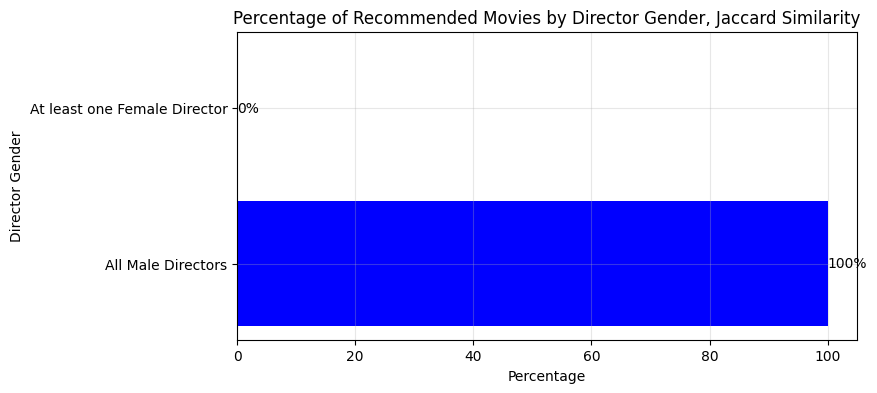

In [61]:
# Calculate proportion of entirely-male directed movies in recommendations
all_male_director_proportion = merged_df[merged_df['MovieID'].isin(list(top_recommendations_reweighed['movie_id']))]['all_male_director'].mean() * 100

# Calculate the proportion of movies with female directors
female_director_proportion = 100 - all_male_director_proportion

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Recommended Movies by Director Gender, Jaccard Similarity')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

The recommender system using Jaccard Similarity's predictions continue to show a lack of diversity despite reweighing the original dataset.

#### Recommender System Bias Mitigation (Cosine Similarity) - Using Reweighed Dataset¶

In [62]:
# Example usage for reweighed dataset
user_id_to_recommend = 1
top_recommendations_reweighed = generate_movie_recommendations_cosine(user_id_to_recommend, movie_user_matrix_reweighed, original_df_reweighed[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Cosine - Reweighted) for User ID {user_id_to_recommend}:\n", top_recommendations_reweighed)

Top 10 Recommended Movies (Cosine - Reweighted) for User ID 1:
    movie_id  Cosine_Similarity
0    1265.0           0.610826
1    1196.0           0.552856
2    1580.0           0.552362
3     356.0           0.551034
4    2396.0           0.533700
5    1198.0           0.530881
6    1923.0           0.523675
7    1210.0           0.521209
8    2716.0           0.519305
9     589.0           0.515537


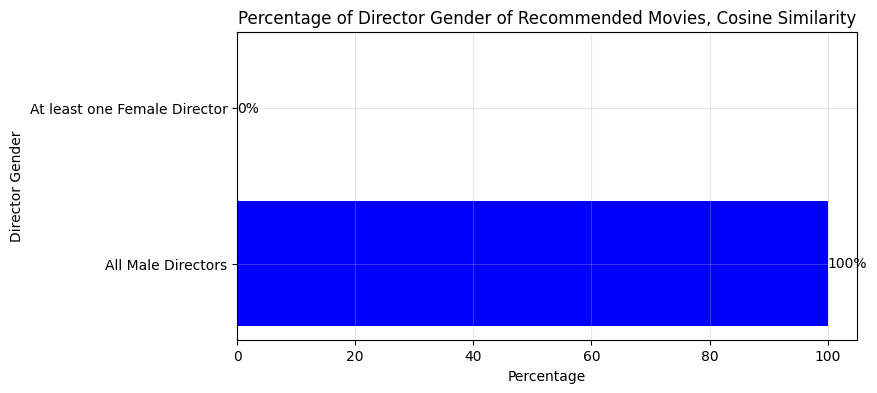

In [63]:
# Calculate proportion of entirely-male directed movies in recommendations
all_male_director_proportion_cosine = merged_df[merged_df['MovieID'].isin(list(top_recommendations_reweighed['movie_id']))]['all_male_director'].mean() * 100

# Calculate the proportion of movies with female directors
female_director_proportion_cosine = 100 - all_male_director_proportion_cosine

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion_cosine, female_director_proportion_cosine]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Director Gender of Recommended Movies, Cosine Similarity')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

The recommender system using Cosine Similarity's predictions also continue to show a lack of diversity despite reweighing the original dataset.

#### Recommender System Bias Mitigation (Pearson) - Using Reweighed Dataset¶

In [64]:
# User 1 as an example
user_id_to_recommend = 1
top_recommendations_pearson_reweighed = generate_movie_recommendations_pearson(user_id_to_recommend, movie_user_matrix_reweighed, original_df_reweighed[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Pearson - Reweighted) for User ID {user_id_to_recommend}:\n", top_recommendations_pearson_reweighed)

Top 10 Recommended Movies (Pearson - Reweighted) for User ID 1:
    movie_id  Pearson_Correlation
0    1265.0             0.407547
1    3253.0             0.370424
2    1923.0             0.357726
3    1517.0             0.347186
4      39.0             0.326788
5    1500.0             0.325082
6     356.0             0.323808
7     500.0             0.308802
8    2174.0             0.306969
9     586.0             0.302354


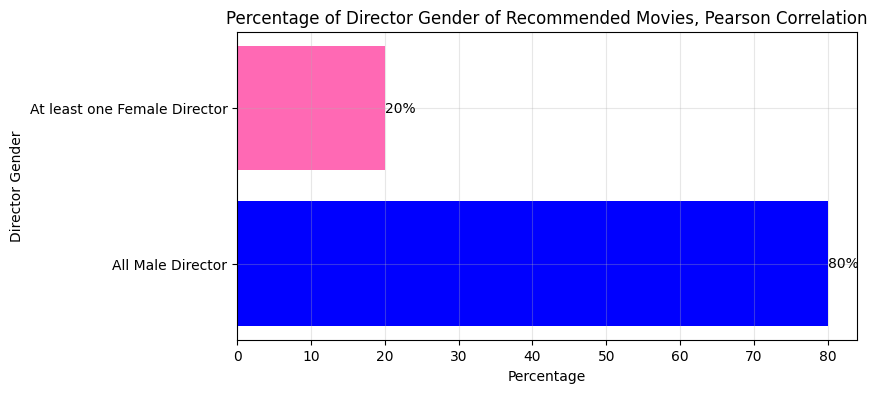

In [65]:
# Calculate proportion of entirely-male directed movies in recommendations
all_male_director_proportion_pearson = merged_df[merged_df['MovieID'].isin(list(top_recommendations_pearson_reweighed['movie_id']))]['all_male_director'].mean() * 100

# Calculate the proportion of movies with female directors
female_director_proportion_pearson = 100 - all_male_director_proportion_pearson

# Create plot
labels = ['All Male Director', 'At least one Female Director']
proportions = [all_male_director_proportion_pearson, female_director_proportion_pearson]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Director Gender of Recommended Movies, Pearson Correlation')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

The percentage of movies with female directors in the recommendations stayed the same as before for all similarity metrics.

Upon doing the same analysis for User 2908, the same results were found, with User 2908's recommendations being exactly the same as before mitigation.

#### Recommender System Bias Mitigation (Surprise)

Like the other similarity metrics above, SVD relies on user-item interaction data to make recommendations. By using a reweighted dataset, which adjusts the representation of male-directed and female-directed movies, we investigate whether there is a difference in recommended movies before and after mitigation.

Per the same approach as the model developed in the section above, the recommender model trains an SVD object using user-item interactions. This time, the dataset the model is trained on has been reweighed. Once again, cross-validation is performed to find the best parameters to assess the model's accuracy for predictions.

##### Reweighing Ratings_and_Movies dataframe before feeding into the SVD algorithm and re-calculating bias metrics

In [66]:
print("Disparate Impact:", aif360_metric_reweighed.disparate_impact())
print("Statistical Parity Difference:", aif360_metric_reweighed.statistical_parity_difference())

Disparate Impact: 0.9999999999999994
Statistical Parity Difference: -1.1102230246251565e-16


##### New rating predictions with reweighed dataset

In [67]:
# Split DataFrame into training & testing sets
trainset_rw, testset_rw = sklearn_train_test_split(aif360_df_reweighed[['movie_id', 'user_id', 'user_rating_copy']], test_size=0.2, random_state=42)

# Initialize SVD algorithm for new DataFrame with reweighed dataset
svd_reweighed = SVD()

# Load data to Surprise Dataset for training
trainset_reweighed = Dataset.load_from_df(trainset_rw[['movie_id', 'user_id', 'user_rating_copy']], reader).build_full_trainset()

# Train algorithm on training set for new DataFrame with reweighed dataset
svd_reweighed.fit(trainset_reweighed)

# Make predictions on testing set
predictions_rw = svd_reweighed.test(testset)

# RMSE (Root Mean Squared Error) of test set
rmse_after = accuracy.rmse(predictions_rw)
print("RMSE After Mitigation:", rmse_after)

# MAE (Mean Absolute Error) of test set
mae_after = accuracy.mae(predictions_rw)
print("MAE After Mitigation:", mae_after)

RMSE: 1.2127
RMSE After Mitigation: 1.2127078190341418
MAE:  0.9880
MAE After Mitigation: 0.9880414966128905


In [68]:
new_all_user_ids = Ratings_and_Movies['user_id'].unique()

new_all_predictions = []

for new_user_id_to_predict in new_all_user_ids:
    new_all_movie_ids = Ratings_and_Movies['movie_id'].unique()
    new_predictions = [(new_user_id_to_predict, movie_id, svd_reweighed.predict(new_user_id_to_predict, movie_id).est) for movie_id in new_all_movie_ids]
    new_all_predictions.extend(new_predictions)


new_predictions_df = pd.DataFrame(new_all_predictions, columns = ['user_id', 'movie_id', 'predicted_rating'])
new_predictions_df['predicted_rating'] = new_predictions_df['predicted_rating'].round()
new_predictions_df = pd.merge(new_predictions_df,
                              Ratings_and_Movies[['user_id', 'movie_id', 'all_male_director']],
                              on = ['user_id', 'movie_id'])

##### Calculating bias metrics for new predictions dataframe since it used the reweighed Ratings_and_Movies dataframe, and model utility

In [69]:
# Create StandardDataset using new predictions dataframe
new_aif360_dataset = StandardDataset(new_predictions_df,
                                 label_name='predicted_rating',
                                 favorable_classes=favorable_classes,
                                 protected_attribute_names=protected_attributes,
                                 privileged_classes=[[1]])

# Calculate disparate impact before any mitigation
new_metric_before = BinaryLabelDatasetMetric(new_aif360_dataset, unprivileged_groups=[{'all_male_director': 0}],
                                         privileged_groups=[{'all_male_director': 1}])
print("Disparate Impact for NEW Predictions DF After Mitigation:", new_metric_before.disparate_impact())
print("Statistical Parity Difference for NEW Predictions DF After Mitigation:", new_metric_before.statistical_parity_difference())

# Store results in table
results_dict = {
    'Disparate Impact After': new_metric_before.disparate_impact(),
    'Statistical Parity Difference After': new_metric_before.statistical_parity_difference(),
    'RMSE After': rmse_after,
    'MAE After': mae_after
}
results_table.loc[results_table['Algorithm'] == 'SVD', results_dict.keys()] = results_dict.values()

Disparate Impact for NEW Predictions DF After Mitigation: 0.7733126316795207
Statistical Parity Difference for NEW Predictions DF After Mitigation: -0.0025982178623710824


The Disparate Impact of the predictions after Reweighing was applied as bias mitigation showed a more fair result. The Disparate Impact before bias mitigation was 0.3693759561648962, increasing to 0.7733126316795207 after. This value approached 1 and indicates a more fair model.

The Statistical Parity Difference was low to begin with (i.e., close to 0) and did not indicate bias in that metric itself.

However, the model utility worsened after Reweighing was applied. The RMSE increased from 0.7146405963914735 to 1.2127078190341418, and the MAE increased from 0.5604532156766929 to 0.9880414966128905. There appears to be a trade-off between model utility and fairness, as the predictive capabilities worsened and will not perform as well.

To verify the results of the bias mitigation, bootstrapping is performed 20 times to account for variability while creating the SVD object. Bootstrapping is a technique that estimates the sampling distribution of a statistic by repeatedly sampling with replacement from the original dataset. This resampling allows us to calculate the fairness metrics several times and summarize it.

In [70]:
# Number of bootstrap iterations
num_bootstraps = 20

# Lists to store disparate impact and statistical parity difference values
disparate_impact_bootstrapped = []
statistical_parity_difference_bootstrapped = []

new_all_movie_ids = Ratings_and_Movies['movie_id'].unique()

# Perform bootstrapping
for _ in range(num_bootstraps):
    
    # Sample set of users
    new_all_user_ids_bootstrapped = np.random.choice(new_all_user_ids, size=len(new_all_user_ids), replace=True)
    new_all_predictions_bootstrapped = []

    for new_user_id_to_predict in new_all_user_ids_bootstrapped:
        new_all_movie_ids = Ratings_and_Movies['movie_id'].unique()
        new_predictions = [(new_user_id_to_predict, movie_id, svd_reweighed.predict(new_user_id_to_predict, movie_id).est) for movie_id in new_all_movie_ids]
        new_all_predictions_bootstrapped.extend(new_predictions)

    new_predictions_df_bootstrapped = pd.DataFrame(new_all_predictions_bootstrapped, columns=['user_id', 'movie_id', 'predicted_rating'])
    new_predictions_df_bootstrapped['predicted_rating'] = new_predictions_df_bootstrapped['predicted_rating'].round()
    new_predictions_df_bootstrapped = pd.merge(new_predictions_df_bootstrapped,
                                               Ratings_and_Movies[['user_id', 'movie_id', 'all_male_director']],
                                               on=['user_id', 'movie_id'])

    # Create a StandardDataset using new predictions dataframe
    new_aif360_dataset_bootstrapped = StandardDataset(new_predictions_df_bootstrapped,
                                                      label_name='predicted_rating',
                                                      favorable_classes=favorable_classes,
                                                      protected_attribute_names=protected_attributes,
                                                      privileged_classes=[[1]])

    # Calculate fairness metrics for the bootstrap sample
    metric_bootstrapped = BinaryLabelDatasetMetric(new_aif360_dataset_bootstrapped, unprivileged_groups=[{'all_male_director': 0}],
                                                   privileged_groups=[{'all_male_director': 1}])
    disparate_impact_bootstrapped.append(metric_bootstrapped.disparate_impact())
    statistical_parity_difference_bootstrapped.append(metric_bootstrapped.statistical_parity_difference())

# Calculate the mean fairness metrics across bootstrapped samples
mean_disparate_impact = np.mean(disparate_impact_bootstrapped)
mean_statistical_parity_difference = np.mean(statistical_parity_difference_bootstrapped)

print("Mean Disparate Impact for NEW Predictions DF After Mitigation:", mean_disparate_impact)
print("Mean Statistical Parity Difference for NEW Predictions DF After Mitigation:", mean_statistical_parity_difference)

Mean Disparate Impact for NEW Predictions DF After Mitigation: 0.7806467001892363
Mean Statistical Parity Difference for NEW Predictions DF After Mitigation: -0.0024737316148945956


The average Disparate Impact over the 20 bootstrap iterations was 0.7806467001892363, which still shows an increase from the Disparate Impact prior to reweighing as a bias mitigation technique.

The average Statistical Parity Difference over the 20 boostrap iterations continues to remain close to 0, meaning this metric fails to identify bias.

#### Making recommendations for user 1 and user 2908 given reweighed predictions
Here we want to recommend movies that we predict the user will give 5 stars. We examine the gender breakdown for recommended movies for User 1 and User 2908.

In [71]:
user_1_predict = new_predictions_df[(new_predictions_df['user_id'] == 1) & (new_predictions_df['predicted_rating'] == 5)]
user_1_predict

,user_id,movie_id,predicted_rating,all_male_director
0,1,1,5.0,1.0
6,1,594,5.0,1.0
8,1,661,5.0,1.0
19,1,1287,5.0,1.0
25,1,2018,5.0,1.0
29,1,2340,5.0,1.0
32,1,2791,5.0,1.0
35,1,3105,5.0,0.0


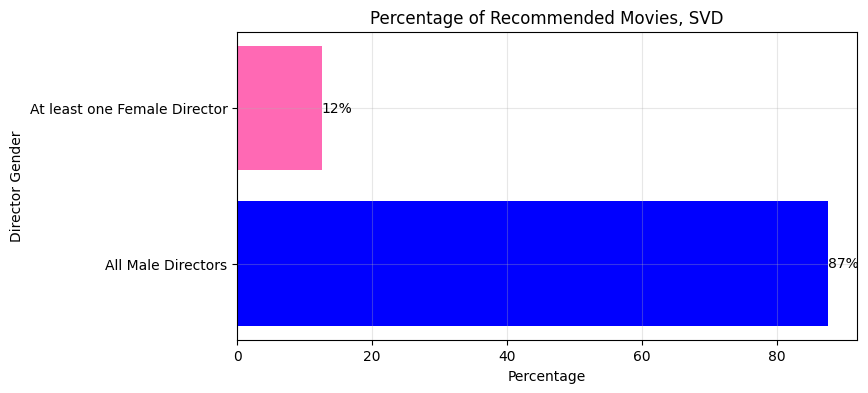

In [72]:
# Calculate proportion of entirely-male directed movies in recommendations
all_male_director_proportion = merged_df[merged_df['MovieID'].isin(list(user_1_predict['movie_id']))]['all_male_director'].mean() * 100

# Calculate the proportion of movies with female directors
female_director_proportion = 100 - all_male_director_proportion

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Recommended Movies, SVD')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

In [73]:
user_2908_predict = new_predictions_df[(new_predictions_df['user_id'] == 2908) & (new_predictions_df['predicted_rating'] == 5)]
if (len(user_2908_predict) < 1):   
    user_2908_predict = new_predictions_df[(new_predictions_df['user_id'] == 2908) & (new_predictions_df['predicted_rating'] == 4)]

user_2908_predict

,user_id,movie_id,predicted_rating,all_male_director
592421,2908,553,5.0,1.0
592423,2908,1407,5.0,1.0
592427,2908,2867,5.0,1.0


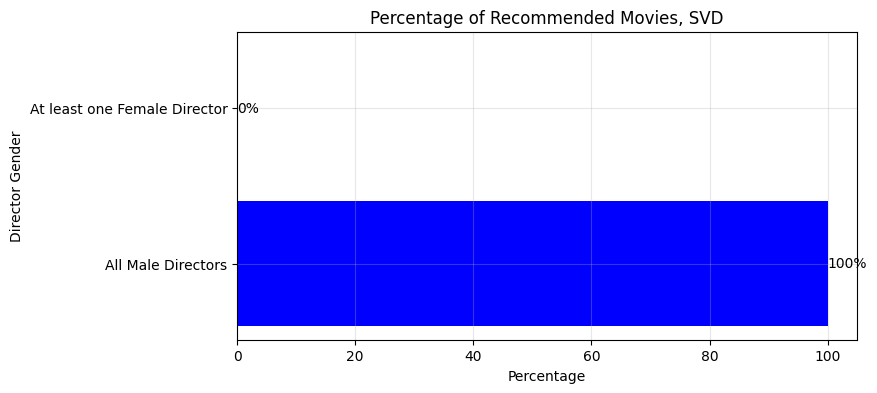

In [74]:
# Calculate proportion of entirely-male directed movies in recommendations
all_male_director_proportion = merged_df[merged_df['MovieID'].isin(list(user_2908_predict['movie_id']))]['all_male_director'].mean() * 100

# Calculate the proportion of movies with female directors
female_director_proportion = 100 - all_male_director_proportion

# Create plot
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Percentage of Recommended Movies, SVD')
plt.xlabel('Percentage')
plt.ylabel('Director Gender')
for i, proportion in enumerate(proportions):
    plt.text(proportion, i, f'{int(proportion)}%', va='center')
plt.grid(alpha=0.3)
plt.show()

Both users received entirely male-directed movies as recommendations, despite having a stark contrast in the diversity of their rating history. Ultimately, we realized that since SVD tries to predict ratings based on how other users have rated the movie, the bias present in other users' recommendations can heavily influence the predicted ratings and, thus, the recommendations from the SVD algorithm, despite our reweighing efforts with AIF360.

Interestingly, User 1 received a greater proportion of movie recommendations featuring female directors, even though User 2908 has a greater proportion in their watch history. Also note that due to the nature of the SVD algorithm, predictions vary each time the code is ran, so the 12% is not a fixed percentage.

### [5.](#Table-of-Contents) Results Summary 

In [75]:
results_table.replace([None, np.nan], 'N/A', inplace=True)
results_table

,Algorithm,Disparate Impact Before,Disparate Impact After,Statistical Parity Difference Before,Statistical Parity Difference After,Accuracy Before,Accuracy After,RMSE Before,RMSE After,MAE Before,MAE After
0,Random Forest Classifier,0.667510,1.000000,-0.074321,8.326673e-17,0.786602,0.787205,N/A,N/A,N/A,N/A
1,SVD,0.369376,0.773313,-0.054608,-2.598218e-03,N/A,N/A,0.714641,1.212708,0.560453,0.988041


Reweighing as a pre-processing bias mitigation technique was successful for the Random Forest Classifier, but remains limited in its application to recommender systems. 

Despite applying the reweighted dataset to the recommender models utilizing Jaccard and Cosine Similarity, and Pearson Correlation, there was no difference in the diversity of movie recommendations. The top movie recommendations continued to exhibit a dominance of male-directed content, indicating that the reweighing technique did not effectively mitigate gender bias in these particular models. It appears that reweighing the dataset did not impact the calculation of the similarity metrics, resulting in the same top 10 movie recommendations before and after bias mitigation in the model.

However, reweighing the recommender system using Surprise (SVD) was able to yield a Disparate Impact closer to the value of 1, effectively mitigating some bias in the original model. The model utility decreases though, making Reweighing not the ideal choice due to lower predictive performance.

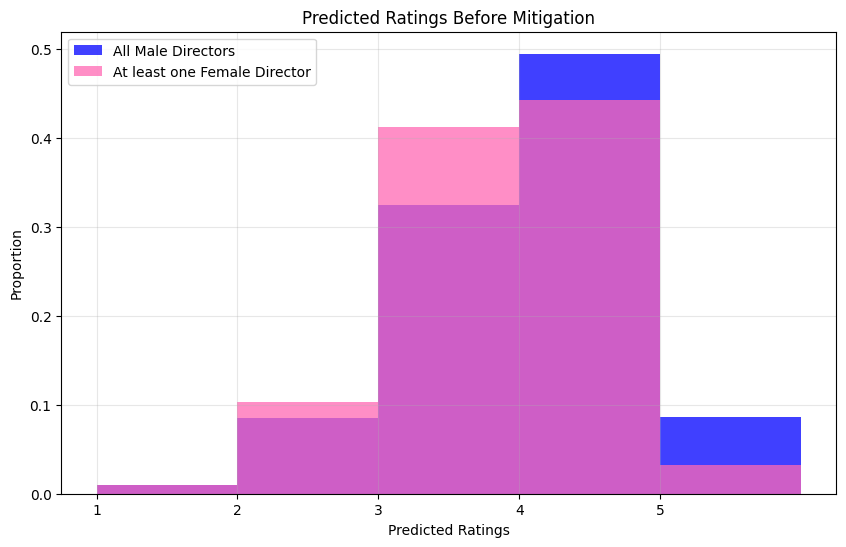

In [76]:
# Define the protected attribute
protected_attribute = 'all_male_director'

# Filter data for male and female directors
male_directors = predictions_df[predictions_df[protected_attribute] == 1]['predicted_rating']
female_directors = predictions_df[predictions_df[protected_attribute] == 0]['predicted_rating']

# Plot histograms for predicted ratings before mitigation
plt.figure(figsize=(10, 6))
plt.hist(male_directors, bins=[1, 2, 3, 4, 5, 6], alpha=0.75, label='All Male Directors', density=True, color='blue')  # Adjust alpha for transparency
plt.hist(female_directors, bins=[1, 2, 3, 4, 5, 6], alpha=0.75, label='At least one Female Director', density=True, color='#FF69B4')  # Adjust alpha for transparency
plt.xlabel('Predicted Ratings')
plt.ylabel('Proportion')
plt.title('Predicted Ratings Before Mitigation')
plt.legend()
plt.xticks(range(1, 6))
plt.grid(alpha=0.3)
plt.show()

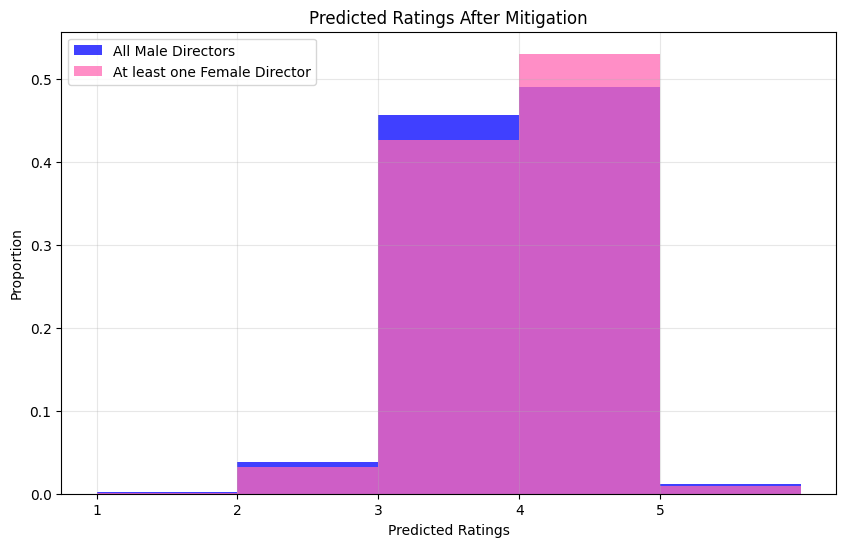

In [77]:
# Predicted ratings after mitigation
male_directors_after_mitigation = new_predictions_df[new_predictions_df[protected_attribute] == 1]['predicted_rating']
female_directors_after_mitigation = new_predictions_df[new_predictions_df[protected_attribute] == 0]['predicted_rating']

# Plot histograms for predicted ratings after mitigation
plt.figure(figsize=(10, 6))
plt.hist(male_directors_after_mitigation, bins=[1, 2, 3, 4, 5, 6], alpha=0.75, label='All Male Directors', density=True, color='blue')  # Adjust alpha for transparency
plt.hist(female_directors_after_mitigation, bins=[1, 2, 3, 4, 5, 6], alpha=0.75, label='At least one Female Director', density=True, color='#FF69B4')  # Adjust alpha for transparency
plt.xlabel('Predicted Ratings')
plt.ylabel('Proportion')
plt.title('Predicted Ratings After Mitigation')
plt.legend()
plt.xticks(range(1, 6)) 
plt.grid(alpha=0.3)
plt.show()

After applying Reweighing, the amount of 5 star ratings (perfect ratings, the favorable outcome) became more equal between entirely-male directed movies & movies featuring female directors.

Yet, after these predictions are converted to recommendations, there appears to still be a gender bias that favors entirely male-directed movies.

### [6.](#Table-of-Contents) Conclusion & Discussion 

The efficacy of AIF360’s Reweighing technique on bias mitigation in recommender systems is subject to ongoing discourse. The topic of recommender systems spans many algorithms and various implementations, and although Reweighing made no difference in the similarity metric based recommender systems, the predictions from SVD was able to see a substantial bias mitgiation. Yet, when the SVD predictions are converted to recommendations, there continues to be a dominance of entirely male-directed films being recommended. This means that there is potential for AIF360 as a bias mitigation tool in recommender systems, although the success of bias mitigation techniques depends on the underlying calculations of the recommender system.

The basis of reweighing lies in addressing dataset imbalances. Because of the underrepresentation of female film directors in the dataset (i.e., most movies were entirely-male directed), reweighing adjusts the distribution of instances across different groups. This may lead to a reduction in the sample size of the majority group to achieve parity, which loses data and can limit the model's ability to capture the full complexity of the dataset.

The definition of "bias" is also arbitrary in our decision to use Disparate Impact and Statistical Parity Difference as the metrics of measurement. As seen in the above sections, the Statistical Parity Difference remained close to 0 in all models, failing to indicate bias. However, the Disparate Impact was able to capture the bias due to failing the 3/4ths rule. Certain metrics are better at capturing bias than others depending on the dynamics of the dataset. So, when it comes to bias mitigation, it depends on the context to decide which bias measures to look at. Even though Disparate Imapct was able to become more fair in the SVD algorithm after mitigation, it is possible other fairness metrics do not.

Additionally, simply examining the director's gender in movie recommender systems is not enough to consider for a model that can impact so many different stakeholders. It is essential to consider how gender can intersect with other demographic factors. For example, a movie recommender system can exhibit different biases based on both the gender and race of the director. The recommender may perform differently for a movie by a Black male director versus a movie by a White male director, despite both movies featuring a male director. As such, intersectionality with gender must be examined as different demographic groups may result in different bias mitigation strategies being the most effective.

Future research in bias mitigation in recommender systems should explore other popular recommender models, like libraries and algorithms such as implicit feedback, PyTorch, or TensorFlow. Ultimately, the goal is to achieve effective bias mitigation in a model with good to exceptional utility. From our research, we believe that bias is not typically mitigated in recommender systems because of how it decreases utility, as seen in the SVD algorithm. Nonetheless, we believe our research is sufficient to continue exploration in using more bias metrics, other models, and other bias mitigation techniques like in-processing and post-processing.

Lastly, while the bias mitigation techniques in this project were able to achieve a more "fair" model in terms of statistical fairness metrics, these techniques do not fully address the underlying systemic biases present in society. The underrepresentation of female-directed movies in the dataset stems from gender biases present in the film industry, where women face more discrimination and receive less support. Technosolutionism refers to the reliance on technological solutions to address complex social issues, ignoring broader societal, ethical, and political implications. Bias mitigation in recommender systems is an important step in achieving fairness and equity in movie recommendation systems, but bias mitigation alone cannot effectively address biases without the work of fields such as sociology, cultural, and media studies to work towards changing the dynamics that influence film production, distribution, and consumption.